In [1]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

sample_rate = 0.5
n_threads = 2 # 4 #number of threads for data loader to use
batchSize = 64 # 32 # 128
nEpochs = 400 # 800
learning_rate = 0.002 #0.0002
beta1 = 0.5 # Adam momentum term
nef = 64 # number of encoder filters in first conv layer
imageSize = 32 # 64
modelE_name = "model_best.pth"
B_residual_block = 8 #8 
train_size_p = 0.9
val_size_p = 1-train_size_p

cuda


In [2]:
import torch
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load CIFAR-10 dataset
download = False
train_set = datasets.CIFAR10(root='./data', train=True, download=download, transform=transform)
test_set = datasets.CIFAR10(root='./data', train=False, download=download, transform=transform)

# Combine train and test sets
full_dataset = torch.utils.data.ConcatDataset([train_set, test_set])
subset = Subset(full_dataset, range(10000))

# Split the dataset (90% training, 10% validation)
train_size = int(train_size_p * len(subset))
val_size = len(subset) - train_size
train_dataset, val_dataset = random_split(subset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True, num_workers=n_threads)
val_loader = DataLoader(val_dataset, batch_size=batchSize, shuffle=False, num_workers=n_threads)

print("CIFAR-10 dataset loaded successfully!")
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")

# Example: Access a batch
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}")

CIFAR-10 dataset loaded successfully!
Number of training images: 9000
Number of validation images: 1000
Batch shape: torch.Size([64, 3, 32, 32])


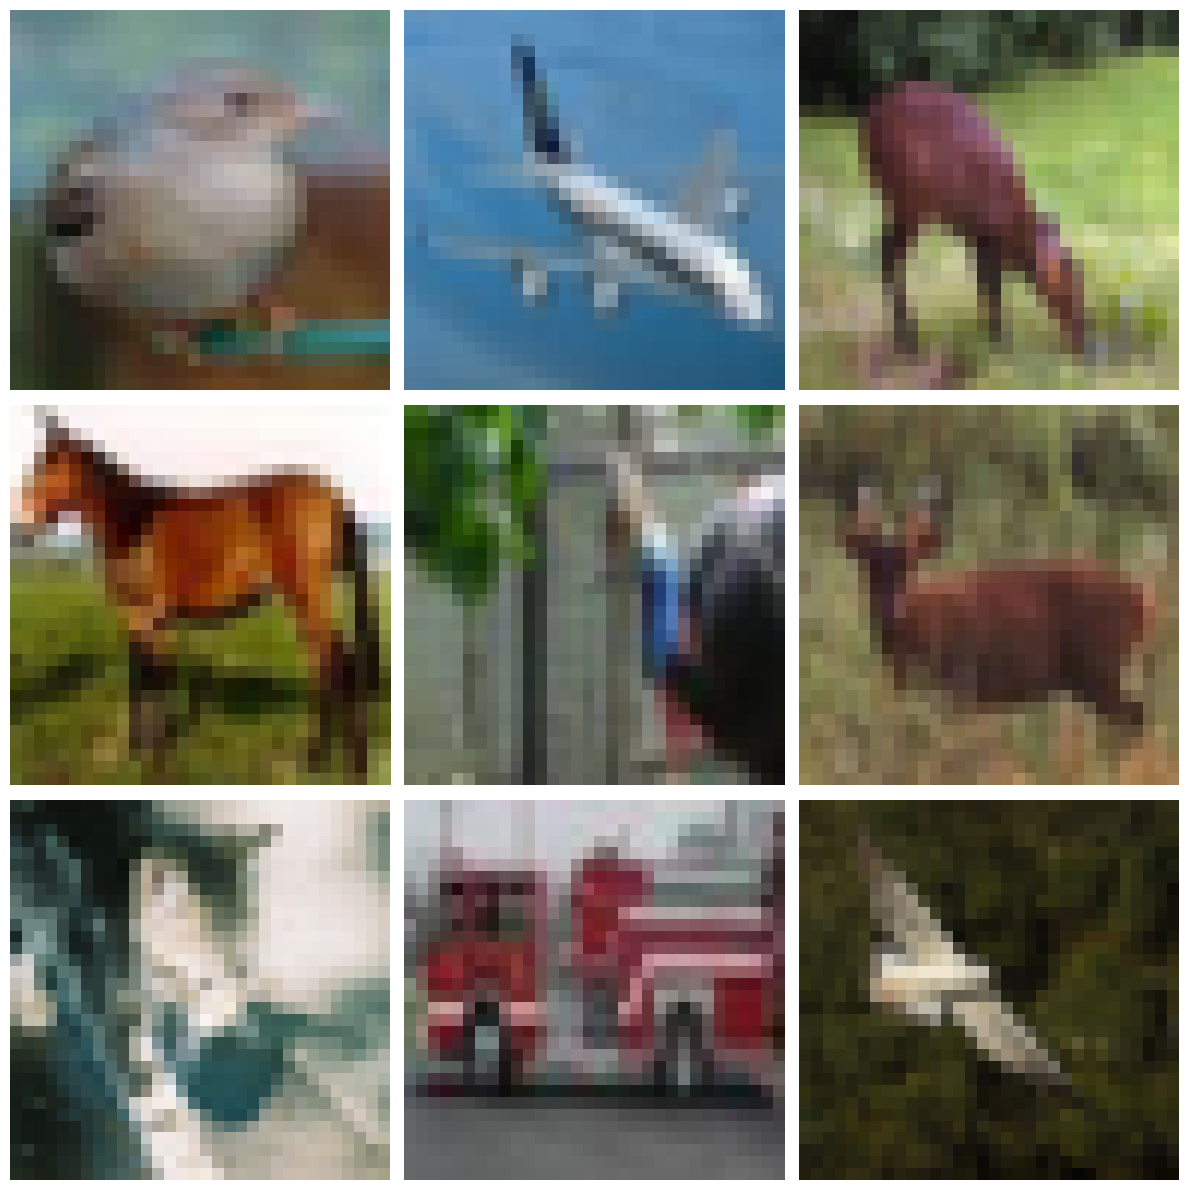

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# Get a batch of images once (instead of inside the loop)
batch = next(iter(train_loader))
imgs, _ = batch  # Unpack images and labels

plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow((imgs[i].permute(1,2,0) + 1.0) / 2.0)
    plt.axis("off")  # Hide axis for better visualization
plt.tight_layout()
plt.show()


In [3]:
import torch.nn as nn
#import torch.nn.functional as F
import torch.nn.init as init
import torch


class AttrProxy(object):
    """Translates index lookups into attribute lookups."""
    def __init__(self, module, prefix):
        self.module = module
        self.prefix = prefix

    def __getitem__(self, i):
        return getattr(self.module, self.prefix + str(i))


class NetE(nn.Module):
    def __init__(self, nef):
        super(NetE, self).__init__()
        # state size: (nc) x 64 x 64
        self.conv1 = nn.Conv2d(3, nef, (4, 4), (2, 2), (1, 1), bias=False)
        self.conv1_bn = nn.BatchNorm2d(nef)
        self.conv1_relu = nn.LeakyReLU(0.2, inplace=False)
        # state size: (nef) x 32 x 32
        self.conv2 = nn.Conv2d(nef, nef*2, (4, 4), (2, 2), (1, 1), bias=False)
        self.conv2_bn = nn.BatchNorm2d(nef*2)
        self.conv2_relu = nn.LeakyReLU(0.2, inplace=False)
        # state size: (nef*2) x 16 x 16
        self.conv3 = nn.Conv2d(nef*2, nef*4, (4, 4), (2, 2), (1, 1), bias=False)
        self.conv3_bn = nn.BatchNorm2d(nef*4)
        self.conv3_relu = nn.LeakyReLU(0.2, inplace=False)
        # state size: (nef*4) x 8 x 8
        self.conv4 = nn.Conv2d(nef*4, nef*8, (4, 4), (2, 2), (1, 1), bias=False)
        self.conv4_bn = nn.BatchNorm2d(nef*8)
        self.conv4_relu = nn.LeakyReLU(0.2, inplace=False)
        # state size: (nef*8) x 4 x 4

        # channel-wise fully connected layer
        self.channel_wise_layers = []
        fla = int(imageSize**2/256)
        for i in range(0, 512):
            self.add_module('channel_wise_layers_' + str(i), nn.Linear(fla, fla))

        self.channel_wise_layers = AttrProxy(self, 'channel_wise_layers_')

        # state size: (nef*8) x 4 x 4
        self.dconv1 = nn.ConvTranspose2d(nef*8, nef*4, (4, 4), (2, 2), (1, 1), bias=False)
        self.dconv1_bn = nn.BatchNorm2d(nef*4)
        self.dconv1_relu = nn.ReLU(inplace=True)
        # state size: (nef*4) x 8 x 8
        self.dconv2 = nn.ConvTranspose2d(nef*4, nef*2, (4, 4), (2, 2), (1, 1), bias=False)
        self.dconv2_bn = nn.BatchNorm2d(nef*2)
        self.dconv2_relu = nn.ReLU(inplace=True)
        # state size: (nef*2) x 16 x 16
        self.dconv3 = nn.ConvTranspose2d(nef*2, nef, (4, 4), (2, 2), (1, 1), bias=False)
        self.dconv3_bn = nn.BatchNorm2d(nef)
        self.dconv3_relu = nn.ReLU(inplace=True)
        # state size: (nef) x 32 x 32
        self.dconv4 = nn.ConvTranspose2d(nef, 3, (4, 4), (2, 2), (1, 1), bias=False)
        self.dconv4_tanh = nn.Tanh()
        # self.dconv1_bn = nn.BatchNorm2d(3)
        # state size: (nc) x 64 x 64

        self._initialize_weights()

    def forward(self, x):
        x = self.conv1_relu(self.conv1_bn(self.conv1(x)))
        x = self.conv2_relu(self.conv2_bn(self.conv2(x)))
        x = self.conv3_relu(self.conv3_bn(self.conv3(x)))
        x = self.conv4_relu(self.conv4_bn(self.conv4(x)))

        for i in range(0, 512):
            slice_cur = x[:,[i],:,:]
            slice_cur_size = slice_cur.size()
            slice_cur = slice_cur.view(slice_cur_size[0], slice_cur_size[2]*slice_cur_size[3])
            slice_cur = self.channel_wise_layers[i](slice_cur)
            x[:,[i],:,:] = slice_cur.view(slice_cur_size[0], slice_cur_size[1], slice_cur_size[2], slice_cur_size[3])

        x = self.dconv1_relu(self.dconv1_bn(self.dconv1(x)))
        x = self.dconv2_relu(self.dconv2_bn(self.dconv2(x)))
        x = self.dconv3_relu(self.dconv3_bn(self.dconv3(x)))
        x = self.dconv4_tanh(self.dconv4(x))
        return x

    def _initialize_weights(self):

        init.normal_(self.conv1_bn.weight,  1.0, 0.02)
        init.normal_(self.conv2_bn.weight,  1.0, 0.02)
        init.normal_(self.conv3_bn.weight,  1.0, 0.02)
        init.normal_(self.conv4_bn.weight,  1.0, 0.02)
        init.normal_(self.dconv1_bn.weight, 1.0, 0.02)
        init.normal_(self.dconv2_bn.weight, 1.0, 0.02)
        init.normal_(self.dconv3_bn.weight, 1.0, 0.02)

        init.constant_(self.conv1_bn.bias,    0.0)
        init.constant_(self.conv2_bn.bias,    0.0)
        init.constant_(self.conv3_bn.bias,    0.0)
        init.constant_(self.conv4_bn.bias,    0.0)
        init.constant_(self.dconv1_bn.bias,   0.0)
        init.constant_(self.dconv2_bn.bias,   0.0)
        init.constant_(self.dconv3_bn.bias,   0.0)

        init.normal_(self.conv1.weight,  0.0, 0.02)
        init.normal_(self.conv2.weight,  0.0, 0.02)
        init.normal_(self.conv3.weight,  0.0, 0.02)
        init.normal_(self.conv4.weight,  0.0, 0.02)
        init.normal_(self.dconv1.weight, 0.0, 0.02)
        init.normal_(self.dconv2.weight, 0.0, 0.02)
        init.normal_(self.dconv3.weight, 0.0, 0.02)
        init.normal_(self.dconv4.weight, 0.0, 0.02)

In [22]:
!pip install tensorboard_logger

In [24]:
from tensorboard_logger import configure
configure("tensorBoardRuns/on-demand-learn-p-02-zero-corrupt-0-conv-bias-0-cwfc-epoch-800")

TypeError: Descriptors cannot be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

## Training

In [23]:
import torch.optim as optim
from math import log10
#from tensorboard_logger import log_value
import os
from tqdm import tqdm
import numpy as np

model = NetE(nef=64)
criterion = nn.MSELoss()

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

print('===> Total Model NetE Parameters:', sum(param.numel() for param in model.parameters()))

print('===> Initialize Optimizer...')
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(beta1, 0.999))

if not os.path.exists("epochs_NetE"):
        os.makedirs("epochs_NetE")

if not os.path.exists("tensorBoardRuns"):
        os.makedirs("tensorBoardRuns")

train_loss = []
train_psnr = []
val_loss = []
val_psnr = []
def train(epoch):
    epoch_loss = 0
    epoch_psnr = 0

    #   Step up learning rate decay
    lr = learning_rate
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999))


    for iteration, batch in tqdm(enumerate(train_loader, 1)):
        target, _ = batch
        batch_size = target.size(0)
        image = target.clone()
        #   Corrupt the target image
        for i in range(0, batch_size):
            corrupt_mask = np.random.binomial(1, (1 - sample_rate), (imageSize, imageSize))
            corrupt_mask.astype(np.uint8)
            #corrupt_mask = torch.ByteTensor(corrupt_mask)
            corrupt_mask = torch.tensor(corrupt_mask, dtype=torch.bool)

            image[i,0,:,:].masked_fill_(corrupt_mask, (0.0))
            image[i,1,:,:].masked_fill_(corrupt_mask, (0.0))
            image[i,2,:,:].masked_fill_(corrupt_mask, (0.0))

        if torch.cuda.is_available():
            image = image.cuda()
            target = target.cuda()

        optimizer.zero_grad()
        loss = criterion((model(image)+1.0)/2.0, (target+1.0)/2.0)
        psnr = 10 * log10(1 / loss.item())
        epoch_loss += loss.item()
        epoch_psnr += psnr
        loss.backward()
        optimizer.step()

    print("===> Epoch {} Complete: lr: {}, Avg. Loss: {:.4f}, Avg.PSNR:  {:.4f} dB".format(epoch, lr, epoch_loss / len(train_loader), epoch_psnr / len(train_loader)))


    #log_value('train_loss', epoch_loss / len(train_loader), epoch)
    #log_value('train_psnr', epoch_psnr / len(train_loader), epoch)

    train_loss.append(epoch_loss / len(train_loader))
    train_psnr.append(epoch_psnr / len(train_loader))

PSNR_best = 0

def val(epoch):
    avg_psnr = 0
    avg_mse = 0
    for batch in val_loader:
        target, _ = batch
        batch_size = target.size(0)
        image = target.clone()
        #   Corrupt the target image
        for i in range(0, batch_size):
            corrupt_mask = np.random.binomial(1, (1 - sample_rate), (imageSize, imageSize))
            corrupt_mask.astype(np.uint8)
            corrupt_mask = torch.tensor(corrupt_mask, dtype=torch.bool)

            image[i,0,:,:].masked_fill_(corrupt_mask, (0.0))
            image[i,1,:,:].masked_fill_(corrupt_mask, (0.0))
            image[i,2,:,:].masked_fill_(corrupt_mask, (0.0))

        if torch.cuda.is_available():
            image = image.cuda()
            target = target.cuda()

        prediction = model(image)
        mse = criterion((prediction+1.0)/2.0, (target+1.0)/2.0)
        psnr = 10 * log10(1 / mse.item())
        avg_psnr += psnr
        avg_mse  += mse.item()
    print("===> Epoch {} Validation: Avg. Loss: {:.4f}, Avg.PSNR:  {:.4f} dB".format(epoch, avg_mse / len(val_loader), avg_psnr / len(val_loader)))

    #log_value('val_loss', avg_mse / len(val_loader), epoch)
    #log_value('val_psnr', avg_psnr / len(val_loader), epoch)

    val_loss.append(avg_mse / len(val_loader))
    val_psnr.append(avg_psnr / len(val_loader))

    global PSNR_best
    if avg_psnr > PSNR_best:
        PSNR_best = avg_psnr
        model_out_path = "epochs_NetE/" + "model_best.pth".format(epoch)
        torch.save(model, model_out_path)
        print("Checkpoint saved to {}".format(model_out_path))

def checkpoint(epoch):
    if epoch%100 == 0:
        model_out_path = "epochs_NetE/" + "model_epoch_{}.pth".format(epoch)
        torch.save(model, model_out_path)
        print("Checkpoint saved to {}".format(model_out_path))

val(0)
checkpoint(0)
for epoch in range(1, nEpochs + 1):
    train(epoch)
    val(epoch)
    checkpoint(epoch)

RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## Trainign NetE

In [4]:
import os
if os.path.exists("epochs_NetE/" + "model_best.pth"):
    model = torch.load("epochs_NetE/" + "model_best.pth")
    print("Model loaded")

Model loaded


In [11]:
import matplotlib.pyplot as plt

def plot_loss(train_losses, val_losses,titre):

    epochs = range(0, len(train_losses))

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Évolution de la "+titre+" au fil des Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

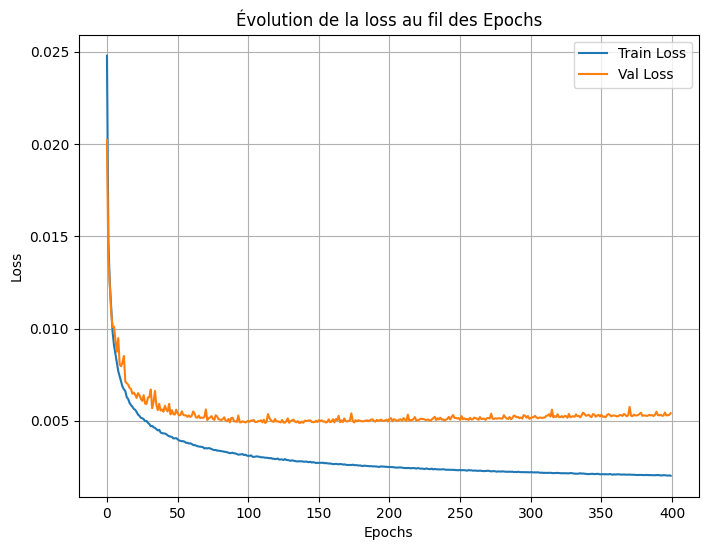

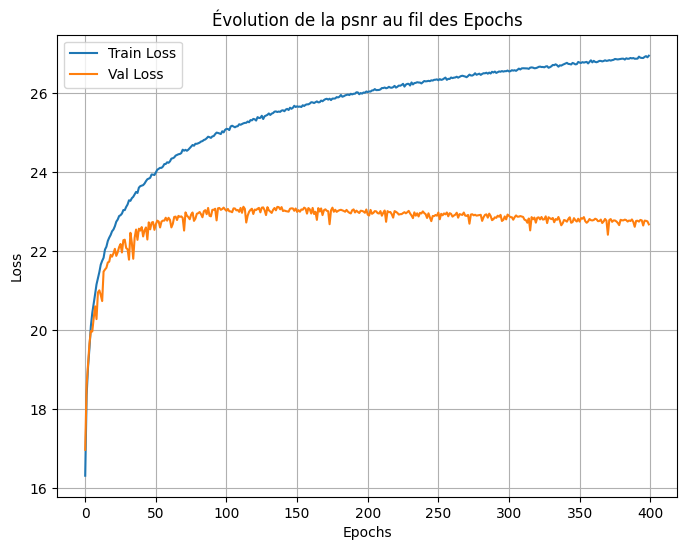

In [13]:
plot_loss(train_loss, val_loss[1:],"loss")
plot_loss(train_psnr, val_psnr[1:],"psnr")

# Test NetE on test data

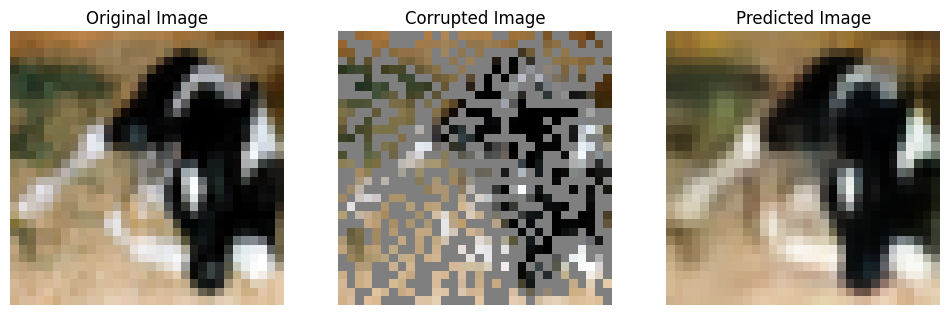

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFile

# Load the image
'''image_path = "Eolienne.jpg"

# Open and preprocess the image
original_image = Image.open(image_path).convert("RGB")
original_image = original_image.resize((imageSize, imageSize), Image.Resampling.LANCZOS)

# Convert to numpy and normalize
original_np = np.asarray(original_image, dtype=np.float32) / 255.0'''
tensor,_ = val_dataset[np.random.randint(0,len(val_dataset)-1)]
original_np = tensor.permute(1, 2, 0).numpy()

# Convert to torch tensor and rearrange dimensions to (C, H, W)
original_tensor = torch.tensor(original_np).permute(2, 0, 1).unsqueeze(0)  # Add batch dimension

# Apply corruption mask
corrupted_np = original_np.copy()
corrupt_mask = np.random.binomial(1, (1 - sample_rate), (imageSize, imageSize)).astype(bool)

# Apply mask to each channel
for i in range(3):  # RGB channels
    corrupted_np[:, :, i][corrupt_mask] = 0.0

# Convert corrupted image to tensor
corrupted_tensor = torch.tensor(corrupted_np).permute(2, 0, 1).unsqueeze(0)

# Move tensors to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
corrupted_tensor = corrupted_tensor.to(device)

# Perform inference
model.eval()
with torch.no_grad():
    predicted_tensor = model(corrupted_tensor)
    predicted_tensor = predicted_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()  # Convert back to (H, W, C)

# Display results
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].imshow((original_np+1.0)/2.0)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow((corrupted_np+1.0)/2.0)
ax[1].set_title("Corrupted Image")
ax[1].axis("off")

ax[2].imshow((predicted_tensor+1.0)/2.0)  # Clip values between 0-1
ax[2].set_title("Predicted Image")
ax[2].axis("off")

plt.show()


# NetM

In [4]:
import torch.nn as nn
#import torch.nn.functional as F
import torch.nn.init as init
import torch
import math
class Mean_Shift(nn.Module):
    def __init__(self, sample_rate=0.2):
        super(Mean_Shift, self).__init__()
        self.sample_rate = sample_rate
        self.sample_rate = torch.autograd.Variable(torch.tensor(sample_rate), requires_grad=False)
        if torch.cuda.is_available(): self.sample_rate = self.sample_rate.cuda()

    def forward(self, x):
        x_size = x.size()

        x_mean = torch.mean(x, 2, True)
        x_mean = torch.mean(x_mean, 3, True)
        x_mean = x_mean.expand(x_size[0], x_size[1], x_size[2], x_size[3])

        x_out = x / x_mean * self.sample_rate

        return x_out


class _Residual_Block(nn.Module):
    def __init__(self):
        super(_Residual_Block, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.in1 = nn.InstanceNorm2d(64, affine=True)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.in2 = nn.InstanceNorm2d(64, affine=True)

    def forward(self, x):
        identity_data = x
        output = self.relu(self.in1(self.conv1(x)))
        output = self.in2(self.conv2(output))
        output = torch.add(output,identity_data)
        return output


class NetM(nn.Module):
    def __init__(self, nef, sample_rate):
        super(NetM, self).__init__()

        self.conv_input = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=9, stride=1, padding=4, bias=False)
        self.relu = nn.LeakyReLU(0.2, inplace=True)

        self.residual = self.make_layer(_Residual_Block, B_residual_block)

        self.conv_mid = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn_mid = nn.InstanceNorm2d(64, affine=True)

        self.conv_output = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=9, stride=1, padding=4, bias=False)
        self.conv_output_bn = nn.BatchNorm2d(1)
        self.conv_output_sig = nn.Sigmoid()

        self.mean_shift = Mean_Shift(sample_rate=sample_rate)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()

    def make_layer(self, block, num_of_layer):
        layers = []
        for _ in range(num_of_layer):
            layers.append(block())
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.conv_input(x))
        residual = out
        out = self.residual(out)
        out = self.bn_mid(self.conv_mid(out))
        out = torch.add(out, residual)

        out = self.conv_output_sig(self.conv_output_bn(self.conv_output(out)))
        out = self.mean_shift(out)

	# iterative mean-clamp, to keep the sample rate precise
        for i in range(0, 25):
            #   Clip to [0, 1]
            out = torch.clamp(out, min=0.0, max=1.0)
            out = self.mean_shift(out)
        out = torch.clamp(out, min=0.0, max=1.0)
        return out

class NetME(nn.Module):
    def __init__(self, nef, NetE_name, sample_rate):
        super(NetME, self).__init__()
        self.netM  = NetM(nef = 64, sample_rate = sample_rate)
        self.netE = NetE(nef = 64)
        self.netE = torch.load(NetE_name, weights_only=False)

    def forward(self, x):
        x_clone = x.clone()
        mask = self.netM(x)
        mask_4d = mask.expand(mask.shape[0], 3, mask.shape[2], mask.shape[3])

        mask_x = mask_4d * x_clone
        x_recon = self.netE(mask_x)

        return mask, x_recon


train NETM


In [ ]:
#from tensorboard_logger import configure
#print('===> Initialize Logger...')
#configure("tensorBoardRuns/mask-train-conti-on-demand-learn-p-02-zero-corrupt-zero-conv-bias-conti-ber-train-v4-cwfc-one-net-eval-h5-val-sig-M-res_net-clip-mean-iter-switch-epoch-800")

===> Initialize Logger...


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from math import log10
#from tensorboard_logger import configure, log_value, log_images
import os
from tqdm import tqdm
import numpy as np
from math import ceil
import gc

torch.cuda.empty_cache()

print('===> Building ME model...')
modelME = NetME(nef = nef, NetE_name = 'epochs_NetE/' + modelE_name, sample_rate = sample_rate)

if torch.cuda.is_available():
    modelME = modelME.cuda()
modelME.netM.train()
modelME.netE.eval()


criterion = nn.MSELoss()

if torch.cuda.is_available():
    criterion = criterion.cuda()

print('===> Total Model NetME Parameters:', sum(param.numel() for param in modelME.parameters()))

print('===> Initialize Optimizer...')
optimizer = optim.Adam([{'params': modelME.netM.parameters(), 'lr': learning_rate},
                        {'params': modelME.netE.parameters(), 'lr': 0.0}
                        ], lr=learning_rate)

if not os.path.exists("epochs_NetME"):
        os.makedirs("epochs_NetME")

if not os.path.exists("tensorBoardRuns"):
        os.makedirs("tensorBoardRuns")

val_loss = []
val_psnr = []
val_sparsity = []
train_loss = []
train_psnr = []
train_sparsity = []

def train(epoch):
    epoch_loss = 0
    epoch_psnr = 0
    epoch_sparsity = 0

    #	train/eval modes make difference on batch normalization layer
    modelME.netM.train()
    modelME.netE.eval()

    #   Step up learning rate decay
    #   No learning rate decay here
    #   Learning rate of NetE is fixed to be 0
    #optimizer = optim.Adam([{'params': modelME.netM.parameters(), 'lr': learning_rate},
                            #{'params': modelME.netE.parameters(), 'lr': 0.0}
                            #], lr=learning_rate)

    for iteration, batch in tqdm(enumerate(train_loader, 1)):
        target, _ = batch
        image = target.clone()

        #	mean_image and std_image are used to compute loss
        mean_image = torch.zeros(image.shape[0], image.shape[1], image.shape[2], image.shape[3])
        mean_image[:,0,:,:] = 0.5
        mean_image[:,1,:,:] = 0.5
        mean_image[:,2,:,:] = 0.5

        std_image = torch.zeros(image.shape[0], image.shape[1], image.shape[2], image.shape[3])
        std_image[:,0,:,:] = 0.5
        std_image[:,1,:,:] = 0.5
        std_image[:,2,:,:] = 0.5

        if torch.cuda.is_available():
            image = image.cuda()
            target = target.cuda()
            mean_image = mean_image.cuda()
            std_image = std_image.cuda()

        optimizer.zero_grad()

        #   Generate the corruption mask and reconstructed image
        corrupt_mask_conti, image_recon = modelME(image)

        mask_sparsity = corrupt_mask_conti.sum() / (corrupt_mask_conti.shape[0] * corrupt_mask_conti.shape[1] * corrupt_mask_conti.shape[2] * corrupt_mask_conti.shape[3])

        loss = criterion((image_recon*std_image)+mean_image, (target*std_image)+mean_image)
        psnr = 10 * log10(1 / loss.item())
        epoch_loss += loss.item()
        epoch_psnr += psnr
        epoch_sparsity += mask_sparsity
        loss.backward()
        optimizer.step()
        
     # 🚀 Explicitly delete unused tensors
    del image, target, mean_image, std_image, corrupt_mask_conti, image_recon, loss
    torch.cuda.empty_cache()

    train_loss.append(epoch_loss / len(train_loader))
    train_psnr.append(epoch_psnr / len(train_loader))
    train_sparsity.append(epoch_sparsity.item() / len(train_loader))

    print("===> Epoch {} Complete: lr: {}, Avg. Loss: {:.4f}, Avg.PSNR:  {:.4f} dB, Mask Sparsity: {:.4f}".format(epoch, learning_rate, epoch_loss / len(train_loader), epoch_psnr / len(train_loader), epoch_sparsity / len(train_loader)))

    #log_value('train_loss', epoch_loss / len(train_loader), epoch)
    #log_value('train_psnr', epoch_psnr / len(train_loader), epoch)
    #log_value('train_sparsity', epoch_sparsity / len(train_loader), epoch)

PSNR_best = 0

def reshape_4D_array(array_4D, width_num):
    num, cha, height, width = array_4D.shape
    height_num = ceil(float(num) / width_num)
    total_width = width * width_num
    total_height = height * height_num
    target_array_4D = np.zeros((1, cha, total_height, total_width))
    for index in range(0, num):
        height_start = index//width_num
        width_start = index%width_num
        target_array_4D[:,:,height_start*height:height_start*height+height,width_start*width:width_start*width+width] = array_4D[index,:,:,:]
    return target_array_4D

def val(epoch):
    avg_psnr = 0
    avg_mse = 0
    avg_sparsity = 0

    modelME.eval()
    modelME.netM.eval()
    modelME.netE.eval()

    with torch.no_grad():
        for batch in val_loader:
            target, _ = batch
            image = target.clone()
            image_clone = image.clone()

            mean_image = torch.zeros(image.shape[0], image.shape[1], image.shape[2], image.shape[3])
            mean_image[:,0,:,:] = 0.5
            mean_image[:,1,:,:] = 0.5
            mean_image[:,2,:,:] = 0.5

            std_image = torch.zeros(image.shape[0], image.shape[1], image.shape[2], image.shape[3])
            std_image[:,0,:,:] = 0.5
            std_image[:,1,:,:] = 0.5
            std_image[:,2,:,:] = 0.5

            if torch.cuda.is_available():
                image = image.cuda()
                image_clone = image_clone.cuda()
                target = target.cuda()
                mean_image = mean_image.cuda()
                std_image = std_image.cuda()

            #   Generate the corruption mask and reconstructed image
            corrupt_mask_conti, _ = modelME(image)
            
            corrupt_mask = corrupt_mask_conti.bernoulli()   # Binarize the corruption mask using Bernoulli distribution, then feed into modelE
            mask_sparsity = corrupt_mask.sum() / (corrupt_mask.shape[0] * corrupt_mask.shape[1] * corrupt_mask.shape[2] * corrupt_mask.shape[3])
            corrupt_mask = corrupt_mask.expand(corrupt_mask.shape[0], 3, corrupt_mask.shape[2], corrupt_mask.shape[3])

            #   Generate the corrupted image
            mask_image = corrupt_mask * image_clone

            restored_image = modelME.netE(mask_image)

            mse = criterion((restored_image*std_image)+mean_image, (target*std_image)+mean_image)
            psnr = 10 * log10(1 / mse.item())
            avg_psnr += psnr
            avg_mse  += mse.item()
            avg_sparsity += mask_sparsity
        # 🚀 Free up memory after validation
        del image, target, mean_image, std_image, corrupt_mask_conti, mask_image, restored_image, mse
        torch.cuda.empty_cache()

    val_loss.append(avg_mse / len(val_loader))
    val_psnr.append(avg_psnr / len(val_loader))
    val_sparsity.append(avg_sparsity.item() / len(val_loader))


    print("===> Epoch {} Validation: Avg. Loss: {:.4f}, Avg.PSNR:  {:.4f} dB, Mask Sparsity: {:.4f}".format(epoch, avg_mse / len(val_loader), avg_psnr / len(val_loader), avg_sparsity / len(val_loader)))

    #log_value('val_loss', avg_mse / len(val_loader), epoch)
    #log_value('val_psnr', avg_psnr / len(val_loader), epoch)
    #log_value('val_sparsity', avg_sparsity / len(val_loader), epoch)

    #corrupt_mask_conti = corrupt_mask_conti.expand(corrupt_mask_conti.shape[0], 3, corrupt_mask_conti.shape[2], corrupt_mask_conti.shape[3])

    # scipy.misc is DEPRECATED and has no attribute toimage
    #log_images('original_image', reshape_4D_array((image*std_image+mean_image).cpu().numpy(), 10), step=1)
    #log_images('conti_mask', reshape_4D_array(corrupt_mask_conti.data.cpu().numpy(), 10), step=1)
    #log_images('binar_mask', reshape_4D_array(corrupt_mask.data.cpu().numpy(), 10), step=1)
    #log_images('restored_image', reshape_4D_array((restored_image*std_image+mean_image).data.cpu().numpy(), 10), step=1)


    global PSNR_best
    if avg_psnr > PSNR_best:
        PSNR_best = avg_psnr
        model_out_path = "epochs_NetME/" + "model_best.pth"
        torch.save(modelME.state_dict(), model_out_path)
        print("Checkpoint saved to {}".format(model_out_path))

def val_rand(epoch):
    avg_psnr = 0
    avg_mse = 0
    avg_sparsity = 0

    modelME.eval()
    modelME.netM.eval()
    modelME.netE.eval()

    with torch.no_grad():
        for batch in val_loader:
            target, _ = batch
            image = target.clone()

            mean_image = torch.zeros(image.shape[0], image.shape[1], image.shape[2], image.shape[3])
            mean_image[:,0,:,:] = 0.5
            mean_image[:,1,:,:] = 0.5
            mean_image[:,2,:,:] = 0.5

            std_image = torch.zeros(image.shape[0], image.shape[1], image.shape[2], image.shape[3])
            std_image[:,0,:,:] = 0.5
            std_image[:,1,:,:] = 0.5
            std_image[:,2,:,:] = 0.5

            #   Generate the random corruption mask
            corrupt_mask = torch.ones(image.shape[0], 1, image.shape[2], image.shape[3])
            corrupt_mask = corrupt_mask * sample_rate
            mask_sparsity = corrupt_mask.sum() / (corrupt_mask.shape[0] * corrupt_mask.shape[1] * corrupt_mask.shape[2] * corrupt_mask.shape[3])
            
            corrupt_mask = corrupt_mask.bernoulli()
            corrupt_mask = corrupt_mask.expand(corrupt_mask.shape[0], 3, corrupt_mask.shape[2], corrupt_mask.shape[3])

            if torch.cuda.is_available():
                image = image.cuda()
                target = target.cuda()
                mean_image = mean_image.cuda()
                std_image = std_image.cuda()
                corrupt_mask = corrupt_mask.cuda()

            #   Generate the corrupted image
            mask_image = corrupt_mask * image

            mse = criterion(( modelME.netE(mask_image)*std_image)+mean_image, (target*std_image)+mean_image)
            psnr = 10 * log10(1 / mse.item())
            avg_psnr += psnr
            avg_mse  += mse.item()
            avg_sparsity += mask_sparsity

    print("===> Epoch {} Random Validation: Avg. Loss: {:.4f}, Avg.PSNR:  {:.4f} dB, Mask Sparsity: {:.4f}".format(epoch, avg_mse / len(val_loader), avg_psnr / len(val_loader), avg_sparsity / len(val_loader)))

    #log_value('val_loss_rand', avg_mse / len(val_loader), epoch)
    #log_value('val_psnr_rand', avg_psnr / len(val_loader), epoch)
    #log_value('val_sparsity_rand', avg_sparsity / len(val_loader), epoch)

def checkpoint(epoch):
    if epoch%100 == 0:
        model_out_path = "epochs_NetME/" + "model_epoch_{}.pth".format(epoch)
        torch.save(modelME.state_dict(), model_out_path)
        print("Checkpoint saved to {}".format(model_out_path))

def cleanup_memory():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()




val(0)
val_rand(0)
checkpoint(0)
for epoch in range(1, nEpochs + 1):
    train(epoch)
    val(epoch)
    val_rand(epoch)
    checkpoint(epoch)

    # 🚀 Call this after every epoch
    cleanup_memory()

===> Building ME model...
===> Total Model NetME Parameters: 6173826
===> Initialize Optimizer...
===> Epoch 0 Validation: Avg. Loss: 0.0065, Avg.PSNR:  21.9119 dB, Mask Sparsity: 0.5002
Checkpoint saved to epochs_NetME/model_best.pth
===> Epoch 0 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4185 dB, Mask Sparsity: 0.5000
Checkpoint saved to epochs_NetME/model_epoch_0.pth


141it [00:51,  2.72it/s]


===> Epoch 1 Complete: lr: 0.002, Avg. Loss: 0.0069, Avg.PSNR:  21.8932 dB, Mask Sparsity: 0.5000
===> Epoch 1 Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.3780 dB, Mask Sparsity: 0.5002
Checkpoint saved to epochs_NetME/model_best.pth
===> Epoch 1 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4284 dB, Mask Sparsity: 0.5000


141it [00:52,  2.70it/s]


===> Epoch 2 Complete: lr: 0.002, Avg. Loss: 0.0036, Avg.PSNR:  24.4304 dB, Mask Sparsity: 0.5000
===> Epoch 2 Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.3884 dB, Mask Sparsity: 0.5000
Checkpoint saved to epochs_NetME/model_best.pth
===> Epoch 2 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4262 dB, Mask Sparsity: 0.5000


141it [00:52,  2.70it/s]


===> Epoch 3 Complete: lr: 0.002, Avg. Loss: 0.0030, Avg.PSNR:  25.1967 dB, Mask Sparsity: 0.5000
===> Epoch 3 Validation: Avg. Loss: 0.0028, Avg.PSNR:  25.4836 dB, Mask Sparsity: 0.5005
Checkpoint saved to epochs_NetME/model_best.pth
===> Epoch 3 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4121 dB, Mask Sparsity: 0.5000


141it [00:51,  2.73it/s]


===> Epoch 4 Complete: lr: 0.002, Avg. Loss: 0.0028, Avg.PSNR:  25.5714 dB, Mask Sparsity: 0.5000
===> Epoch 4 Validation: Avg. Loss: 0.0028, Avg.PSNR:  25.4749 dB, Mask Sparsity: 0.4997
===> Epoch 4 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4441 dB, Mask Sparsity: 0.5000


141it [00:50,  2.77it/s]


===> Epoch 5 Complete: lr: 0.002, Avg. Loss: 0.0027, Avg.PSNR:  25.6409 dB, Mask Sparsity: 0.5000
===> Epoch 5 Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4584 dB, Mask Sparsity: 0.5000
===> Epoch 5 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4358 dB, Mask Sparsity: 0.5000


141it [00:52,  2.69it/s]


===> Epoch 6 Complete: lr: 0.002, Avg. Loss: 0.0027, Avg.PSNR:  25.7071 dB, Mask Sparsity: 0.5000
===> Epoch 6 Validation: Avg. Loss: 0.0027, Avg.PSNR:  25.6293 dB, Mask Sparsity: 0.4997
Checkpoint saved to epochs_NetME/model_best.pth
===> Epoch 6 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4311 dB, Mask Sparsity: 0.5000


141it [00:52,  2.67it/s]


===> Epoch 7 Complete: lr: 0.002, Avg. Loss: 0.0026, Avg.PSNR:  25.8687 dB, Mask Sparsity: 0.5000
===> Epoch 7 Validation: Avg. Loss: 0.0027, Avg.PSNR:  25.6741 dB, Mask Sparsity: 0.5003
Checkpoint saved to epochs_NetME/model_best.pth
===> Epoch 7 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4202 dB, Mask Sparsity: 0.5000


141it [00:52,  2.70it/s]


===> Epoch 8 Complete: lr: 0.002, Avg. Loss: 0.0026, Avg.PSNR:  25.9118 dB, Mask Sparsity: 0.5000
===> Epoch 8 Validation: Avg. Loss: 0.0027, Avg.PSNR:  25.7117 dB, Mask Sparsity: 0.5003
Checkpoint saved to epochs_NetME/model_best.pth
===> Epoch 8 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4343 dB, Mask Sparsity: 0.5000


141it [00:50,  2.80it/s]


===> Epoch 9 Complete: lr: 0.002, Avg. Loss: 0.0025, Avg.PSNR:  25.9546 dB, Mask Sparsity: 0.5000
===> Epoch 9 Validation: Avg. Loss: 0.0026, Avg.PSNR:  25.7943 dB, Mask Sparsity: 0.5002
Checkpoint saved to epochs_NetME/model_best.pth
===> Epoch 9 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4290 dB, Mask Sparsity: 0.5000


141it [00:50,  2.82it/s]


===> Epoch 10 Complete: lr: 0.002, Avg. Loss: 0.0025, Avg.PSNR:  26.0038 dB, Mask Sparsity: 0.5000
===> Epoch 10 Validation: Avg. Loss: 0.0026, Avg.PSNR:  25.8481 dB, Mask Sparsity: 0.4996
Checkpoint saved to epochs_NetME/model_best.pth
===> Epoch 10 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4329 dB, Mask Sparsity: 0.5000


141it [00:50,  2.77it/s]


===> Epoch 11 Complete: lr: 0.002, Avg. Loss: 0.0025, Avg.PSNR:  26.0235 dB, Mask Sparsity: 0.5000
===> Epoch 11 Validation: Avg. Loss: 0.0026, Avg.PSNR:  25.8540 dB, Mask Sparsity: 0.5000
Checkpoint saved to epochs_NetME/model_best.pth
===> Epoch 11 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4145 dB, Mask Sparsity: 0.5000


141it [00:51,  2.71it/s]


===> Epoch 12 Complete: lr: 0.002, Avg. Loss: 0.0025, Avg.PSNR:  26.0506 dB, Mask Sparsity: 0.5000
===> Epoch 12 Validation: Avg. Loss: 0.0026, Avg.PSNR:  25.9200 dB, Mask Sparsity: 0.5000
Checkpoint saved to epochs_NetME/model_best.pth
===> Epoch 12 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4212 dB, Mask Sparsity: 0.5000


141it [00:50,  2.78it/s]


===> Epoch 13 Complete: lr: 0.002, Avg. Loss: 0.0025, Avg.PSNR:  26.0332 dB, Mask Sparsity: 0.5000
===> Epoch 13 Validation: Avg. Loss: 0.0026, Avg.PSNR:  25.8236 dB, Mask Sparsity: 0.4998
===> Epoch 13 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4322 dB, Mask Sparsity: 0.5000


141it [00:51,  2.72it/s]


===> Epoch 14 Complete: lr: 0.002, Avg. Loss: 0.0025, Avg.PSNR:  26.0283 dB, Mask Sparsity: 0.5000
===> Epoch 14 Validation: Avg. Loss: 0.0026, Avg.PSNR:  25.9258 dB, Mask Sparsity: 0.5002
Checkpoint saved to epochs_NetME/model_best.pth
===> Epoch 14 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4167 dB, Mask Sparsity: 0.5000


141it [00:52,  2.68it/s]


===> Epoch 15 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.1265 dB, Mask Sparsity: 0.5000
===> Epoch 15 Validation: Avg. Loss: 0.0026, Avg.PSNR:  25.9226 dB, Mask Sparsity: 0.5002
===> Epoch 15 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4333 dB, Mask Sparsity: 0.5000


141it [00:53,  2.61it/s]


===> Epoch 16 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.1444 dB, Mask Sparsity: 0.5000
===> Epoch 16 Validation: Avg. Loss: 0.0025, Avg.PSNR:  25.9760 dB, Mask Sparsity: 0.5002
Checkpoint saved to epochs_NetME/model_best.pth
===> Epoch 16 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4180 dB, Mask Sparsity: 0.5000


141it [00:52,  2.66it/s]


===> Epoch 17 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.1636 dB, Mask Sparsity: 0.5000
===> Epoch 17 Validation: Avg. Loss: 0.0025, Avg.PSNR:  25.9476 dB, Mask Sparsity: 0.4998
===> Epoch 17 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4293 dB, Mask Sparsity: 0.5000


141it [00:53,  2.65it/s]


===> Epoch 18 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.1636 dB, Mask Sparsity: 0.5000
===> Epoch 18 Validation: Avg. Loss: 0.0026, Avg.PSNR:  25.9223 dB, Mask Sparsity: 0.4998
===> Epoch 18 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4004 dB, Mask Sparsity: 0.5000


141it [00:52,  2.69it/s]


===> Epoch 19 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.1452 dB, Mask Sparsity: 0.5000
===> Epoch 19 Validation: Avg. Loss: 0.0026, Avg.PSNR:  25.9309 dB, Mask Sparsity: 0.5001
===> Epoch 19 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4443 dB, Mask Sparsity: 0.5000


141it [00:51,  2.71it/s]


===> Epoch 20 Complete: lr: 0.002, Avg. Loss: 0.0025, Avg.PSNR:  26.1077 dB, Mask Sparsity: 0.5000
===> Epoch 20 Validation: Avg. Loss: 0.0025, Avg.PSNR:  25.9744 dB, Mask Sparsity: 0.4999
===> Epoch 20 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4438 dB, Mask Sparsity: 0.5000


141it [00:52,  2.67it/s]


===> Epoch 21 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.1739 dB, Mask Sparsity: 0.5000
===> Epoch 21 Validation: Avg. Loss: 0.0025, Avg.PSNR:  25.9791 dB, Mask Sparsity: 0.4999
Checkpoint saved to epochs_NetME/model_best.pth
===> Epoch 21 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4345 dB, Mask Sparsity: 0.5000


141it [00:59,  2.37it/s]


===> Epoch 22 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.1649 dB, Mask Sparsity: 0.5000
===> Epoch 22 Validation: Avg. Loss: 0.0025, Avg.PSNR:  25.9715 dB, Mask Sparsity: 0.5000
===> Epoch 22 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4475 dB, Mask Sparsity: 0.5000


141it [00:54,  2.61it/s]


===> Epoch 23 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.1763 dB, Mask Sparsity: 0.5000
===> Epoch 23 Validation: Avg. Loss: 0.0025, Avg.PSNR:  25.9638 dB, Mask Sparsity: 0.5003
===> Epoch 23 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4237 dB, Mask Sparsity: 0.5000


141it [00:54,  2.57it/s]


===> Epoch 24 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.2147 dB, Mask Sparsity: 0.5000
===> Epoch 24 Validation: Avg. Loss: 0.0025, Avg.PSNR:  25.9614 dB, Mask Sparsity: 0.4996
===> Epoch 24 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4242 dB, Mask Sparsity: 0.5000


141it [00:54,  2.61it/s]


===> Epoch 25 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.2286 dB, Mask Sparsity: 0.5000
===> Epoch 25 Validation: Avg. Loss: 0.0026, Avg.PSNR:  25.9313 dB, Mask Sparsity: 0.5003
===> Epoch 25 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4398 dB, Mask Sparsity: 0.5000


141it [00:53,  2.64it/s]


===> Epoch 26 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.1974 dB, Mask Sparsity: 0.5000
===> Epoch 26 Validation: Avg. Loss: 0.0025, Avg.PSNR:  25.9641 dB, Mask Sparsity: 0.4997
===> Epoch 26 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4239 dB, Mask Sparsity: 0.5000


141it [00:52,  2.67it/s]


===> Epoch 27 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.2598 dB, Mask Sparsity: 0.5000
===> Epoch 27 Validation: Avg. Loss: 0.0026, Avg.PSNR:  25.9237 dB, Mask Sparsity: 0.5000
===> Epoch 27 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4218 dB, Mask Sparsity: 0.5000


141it [00:52,  2.70it/s]


===> Epoch 28 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.2562 dB, Mask Sparsity: 0.5000
===> Epoch 28 Validation: Avg. Loss: 0.0025, Avg.PSNR:  25.9701 dB, Mask Sparsity: 0.5000
===> Epoch 28 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4336 dB, Mask Sparsity: 0.5000


141it [00:52,  2.68it/s]


===> Epoch 29 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.2538 dB, Mask Sparsity: 0.5000
===> Epoch 29 Validation: Avg. Loss: 0.0025, Avg.PSNR:  25.9854 dB, Mask Sparsity: 0.5003
Checkpoint saved to epochs_NetME/model_best.pth
===> Epoch 29 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4248 dB, Mask Sparsity: 0.5000


141it [00:52,  2.69it/s]


===> Epoch 30 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.2394 dB, Mask Sparsity: 0.5000
===> Epoch 30 Validation: Avg. Loss: 0.0025, Avg.PSNR:  25.9766 dB, Mask Sparsity: 0.4999
===> Epoch 30 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4299 dB, Mask Sparsity: 0.5000


141it [00:51,  2.73it/s]


===> Epoch 31 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.2341 dB, Mask Sparsity: 0.5000
===> Epoch 31 Validation: Avg. Loss: 0.0025, Avg.PSNR:  25.9697 dB, Mask Sparsity: 0.5004
===> Epoch 31 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4104 dB, Mask Sparsity: 0.5000


141it [00:51,  2.76it/s]


===> Epoch 32 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.2712 dB, Mask Sparsity: 0.5000
===> Epoch 32 Validation: Avg. Loss: 0.0025, Avg.PSNR:  25.9761 dB, Mask Sparsity: 0.4996
===> Epoch 32 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4342 dB, Mask Sparsity: 0.5000


141it [00:51,  2.76it/s]


===> Epoch 33 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.2779 dB, Mask Sparsity: 0.5000
===> Epoch 33 Validation: Avg. Loss: 0.0025, Avg.PSNR:  25.9764 dB, Mask Sparsity: 0.4999
===> Epoch 33 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4396 dB, Mask Sparsity: 0.5000


141it [00:51,  2.75it/s]


===> Epoch 34 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.2541 dB, Mask Sparsity: 0.5000
===> Epoch 34 Validation: Avg. Loss: 0.0025, Avg.PSNR:  25.9940 dB, Mask Sparsity: 0.4998
Checkpoint saved to epochs_NetME/model_best.pth
===> Epoch 34 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4301 dB, Mask Sparsity: 0.5000


141it [00:51,  2.75it/s]


===> Epoch 35 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.2661 dB, Mask Sparsity: 0.5000
===> Epoch 35 Validation: Avg. Loss: 0.0025, Avg.PSNR:  25.9916 dB, Mask Sparsity: 0.5003
===> Epoch 35 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4189 dB, Mask Sparsity: 0.5000


141it [00:51,  2.76it/s]


===> Epoch 36 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.2711 dB, Mask Sparsity: 0.5000
===> Epoch 36 Validation: Avg. Loss: 0.0025, Avg.PSNR:  25.9459 dB, Mask Sparsity: 0.5001
===> Epoch 36 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4292 dB, Mask Sparsity: 0.5000


141it [00:53,  2.66it/s]


===> Epoch 37 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.2339 dB, Mask Sparsity: 0.5000
===> Epoch 37 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0218 dB, Mask Sparsity: 0.5000
Checkpoint saved to epochs_NetME/model_best.pth
===> Epoch 37 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4174 dB, Mask Sparsity: 0.5000


141it [00:52,  2.66it/s]


===> Epoch 38 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.2260 dB, Mask Sparsity: 0.5000
===> Epoch 38 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0191 dB, Mask Sparsity: 0.5000
===> Epoch 38 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4375 dB, Mask Sparsity: 0.5000


141it [00:52,  2.68it/s]


===> Epoch 39 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.2407 dB, Mask Sparsity: 0.5000
===> Epoch 39 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0330 dB, Mask Sparsity: 0.4998
Checkpoint saved to epochs_NetME/model_best.pth
===> Epoch 39 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4224 dB, Mask Sparsity: 0.5000


141it [01:00,  2.32it/s]


===> Epoch 40 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.2756 dB, Mask Sparsity: 0.5000
===> Epoch 40 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0291 dB, Mask Sparsity: 0.5001
===> Epoch 40 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4039 dB, Mask Sparsity: 0.5000


141it [00:55,  2.52it/s]


===> Epoch 41 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.2909 dB, Mask Sparsity: 0.5000
===> Epoch 41 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0206 dB, Mask Sparsity: 0.4999
===> Epoch 41 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4135 dB, Mask Sparsity: 0.5000


141it [00:55,  2.54it/s]


===> Epoch 42 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.2937 dB, Mask Sparsity: 0.5000
===> Epoch 42 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0237 dB, Mask Sparsity: 0.5001
===> Epoch 42 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4185 dB, Mask Sparsity: 0.5000


141it [00:54,  2.59it/s]


===> Epoch 43 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.2588 dB, Mask Sparsity: 0.5000
===> Epoch 43 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0321 dB, Mask Sparsity: 0.5002
===> Epoch 43 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4168 dB, Mask Sparsity: 0.5000


141it [00:54,  2.60it/s]


===> Epoch 44 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.2968 dB, Mask Sparsity: 0.5000
===> Epoch 44 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0125 dB, Mask Sparsity: 0.5001
===> Epoch 44 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4297 dB, Mask Sparsity: 0.5000


141it [00:52,  2.67it/s]


===> Epoch 45 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3156 dB, Mask Sparsity: 0.5000
===> Epoch 45 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0403 dB, Mask Sparsity: 0.5001
Checkpoint saved to epochs_NetME/model_best.pth
===> Epoch 45 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4384 dB, Mask Sparsity: 0.5000


141it [00:52,  2.71it/s]


===> Epoch 46 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3233 dB, Mask Sparsity: 0.5000
===> Epoch 46 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0253 dB, Mask Sparsity: 0.4998
===> Epoch 46 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4120 dB, Mask Sparsity: 0.5000


141it [00:54,  2.59it/s]


===> Epoch 47 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3322 dB, Mask Sparsity: 0.5000
===> Epoch 47 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0170 dB, Mask Sparsity: 0.5001
===> Epoch 47 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4350 dB, Mask Sparsity: 0.5000


141it [00:54,  2.58it/s]


===> Epoch 48 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3208 dB, Mask Sparsity: 0.5000
===> Epoch 48 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0251 dB, Mask Sparsity: 0.5000
===> Epoch 48 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4306 dB, Mask Sparsity: 0.5000


141it [00:52,  2.67it/s]


===> Epoch 49 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.2510 dB, Mask Sparsity: 0.5000
===> Epoch 49 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0484 dB, Mask Sparsity: 0.5003
Checkpoint saved to epochs_NetME/model_best.pth
===> Epoch 49 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4452 dB, Mask Sparsity: 0.5000


141it [00:51,  2.73it/s]


===> Epoch 50 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.2674 dB, Mask Sparsity: 0.5000
===> Epoch 50 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0547 dB, Mask Sparsity: 0.4998
Checkpoint saved to epochs_NetME/model_best.pth
===> Epoch 50 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4241 dB, Mask Sparsity: 0.5000


141it [00:51,  2.73it/s]


===> Epoch 51 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.2989 dB, Mask Sparsity: 0.5000
===> Epoch 51 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0294 dB, Mask Sparsity: 0.4996
===> Epoch 51 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4303 dB, Mask Sparsity: 0.5000


141it [00:51,  2.75it/s]


===> Epoch 52 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3214 dB, Mask Sparsity: 0.5000
===> Epoch 52 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0442 dB, Mask Sparsity: 0.5002
===> Epoch 52 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4124 dB, Mask Sparsity: 0.5000


141it [00:51,  2.75it/s]


===> Epoch 53 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3336 dB, Mask Sparsity: 0.5000
===> Epoch 53 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0650 dB, Mask Sparsity: 0.4997
Checkpoint saved to epochs_NetME/model_best.pth
===> Epoch 53 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4374 dB, Mask Sparsity: 0.5000


141it [00:51,  2.74it/s]


===> Epoch 54 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3159 dB, Mask Sparsity: 0.5000
===> Epoch 54 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0302 dB, Mask Sparsity: 0.4999
===> Epoch 54 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4294 dB, Mask Sparsity: 0.5000


141it [00:51,  2.72it/s]


===> Epoch 55 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3199 dB, Mask Sparsity: 0.5000
===> Epoch 55 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0190 dB, Mask Sparsity: 0.5002
===> Epoch 55 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4471 dB, Mask Sparsity: 0.5000


141it [00:51,  2.74it/s]


===> Epoch 56 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3141 dB, Mask Sparsity: 0.5000
===> Epoch 56 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0136 dB, Mask Sparsity: 0.5000
===> Epoch 56 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4168 dB, Mask Sparsity: 0.5000


141it [00:51,  2.73it/s]


===> Epoch 57 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3247 dB, Mask Sparsity: 0.5000
===> Epoch 57 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0342 dB, Mask Sparsity: 0.4999
===> Epoch 57 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4277 dB, Mask Sparsity: 0.5000


141it [00:51,  2.73it/s]


===> Epoch 58 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3246 dB, Mask Sparsity: 0.5000
===> Epoch 58 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0497 dB, Mask Sparsity: 0.5005
===> Epoch 58 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4272 dB, Mask Sparsity: 0.5000


141it [00:51,  2.73it/s]


===> Epoch 59 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3141 dB, Mask Sparsity: 0.5000
===> Epoch 59 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0651 dB, Mask Sparsity: 0.4998
Checkpoint saved to epochs_NetME/model_best.pth
===> Epoch 59 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4305 dB, Mask Sparsity: 0.5000


141it [00:51,  2.73it/s]


===> Epoch 60 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.2961 dB, Mask Sparsity: 0.5000
===> Epoch 60 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0711 dB, Mask Sparsity: 0.4999
Checkpoint saved to epochs_NetME/model_best.pth
===> Epoch 60 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4416 dB, Mask Sparsity: 0.5000


141it [00:51,  2.75it/s]


===> Epoch 61 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.2961 dB, Mask Sparsity: 0.5000
===> Epoch 61 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0429 dB, Mask Sparsity: 0.4999
===> Epoch 61 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.3868 dB, Mask Sparsity: 0.5000


141it [00:51,  2.75it/s]


===> Epoch 62 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3248 dB, Mask Sparsity: 0.5000
===> Epoch 62 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0587 dB, Mask Sparsity: 0.4999
===> Epoch 62 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.3953 dB, Mask Sparsity: 0.5000


141it [00:51,  2.76it/s]


===> Epoch 63 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3231 dB, Mask Sparsity: 0.5000
===> Epoch 63 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0404 dB, Mask Sparsity: 0.5000
===> Epoch 63 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4053 dB, Mask Sparsity: 0.5000


141it [00:51,  2.74it/s]


===> Epoch 64 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3174 dB, Mask Sparsity: 0.5000
===> Epoch 64 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0652 dB, Mask Sparsity: 0.5001
===> Epoch 64 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4202 dB, Mask Sparsity: 0.5000


141it [00:51,  2.74it/s]


===> Epoch 65 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3264 dB, Mask Sparsity: 0.5000
===> Epoch 65 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0365 dB, Mask Sparsity: 0.5000
===> Epoch 65 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4190 dB, Mask Sparsity: 0.5000


141it [00:51,  2.75it/s]


===> Epoch 66 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3267 dB, Mask Sparsity: 0.5000
===> Epoch 66 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0228 dB, Mask Sparsity: 0.4998
===> Epoch 66 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.3959 dB, Mask Sparsity: 0.5000


141it [00:51,  2.76it/s]


===> Epoch 67 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3160 dB, Mask Sparsity: 0.5000
===> Epoch 67 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0269 dB, Mask Sparsity: 0.4998
===> Epoch 67 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4414 dB, Mask Sparsity: 0.5000


141it [00:51,  2.75it/s]


===> Epoch 68 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3238 dB, Mask Sparsity: 0.5000
===> Epoch 68 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0363 dB, Mask Sparsity: 0.4996
===> Epoch 68 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4176 dB, Mask Sparsity: 0.5000


141it [00:51,  2.73it/s]


===> Epoch 69 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3211 dB, Mask Sparsity: 0.5000
===> Epoch 69 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0544 dB, Mask Sparsity: 0.4996
===> Epoch 69 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4253 dB, Mask Sparsity: 0.5000


141it [00:51,  2.74it/s]


===> Epoch 70 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3272 dB, Mask Sparsity: 0.5000
===> Epoch 70 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0500 dB, Mask Sparsity: 0.5002
===> Epoch 70 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4095 dB, Mask Sparsity: 0.5000


141it [00:51,  2.73it/s]


===> Epoch 71 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3014 dB, Mask Sparsity: 0.5000
===> Epoch 71 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0284 dB, Mask Sparsity: 0.4999
===> Epoch 71 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4194 dB, Mask Sparsity: 0.5000


141it [00:51,  2.73it/s]


===> Epoch 72 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3254 dB, Mask Sparsity: 0.5000
===> Epoch 72 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0161 dB, Mask Sparsity: 0.5001
===> Epoch 72 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4201 dB, Mask Sparsity: 0.5000


141it [00:51,  2.72it/s]


===> Epoch 73 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.2962 dB, Mask Sparsity: 0.5000
===> Epoch 73 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0651 dB, Mask Sparsity: 0.4997
===> Epoch 73 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4274 dB, Mask Sparsity: 0.5000


141it [00:51,  2.73it/s]


===> Epoch 74 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3201 dB, Mask Sparsity: 0.5000
===> Epoch 74 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0521 dB, Mask Sparsity: 0.4999
===> Epoch 74 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4331 dB, Mask Sparsity: 0.5000


141it [00:51,  2.75it/s]


===> Epoch 75 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3497 dB, Mask Sparsity: 0.5000
===> Epoch 75 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0646 dB, Mask Sparsity: 0.5000
===> Epoch 75 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4042 dB, Mask Sparsity: 0.5000


141it [00:51,  2.74it/s]


===> Epoch 76 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3387 dB, Mask Sparsity: 0.5000
===> Epoch 76 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.1036 dB, Mask Sparsity: 0.5000
Checkpoint saved to epochs_NetME/model_best.pth
===> Epoch 76 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4148 dB, Mask Sparsity: 0.5000


141it [00:51,  2.74it/s]


===> Epoch 77 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.2873 dB, Mask Sparsity: 0.5000
===> Epoch 77 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0549 dB, Mask Sparsity: 0.5000
===> Epoch 77 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4277 dB, Mask Sparsity: 0.5000


141it [00:51,  2.74it/s]


===> Epoch 78 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3201 dB, Mask Sparsity: 0.5000
===> Epoch 78 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0909 dB, Mask Sparsity: 0.5000
===> Epoch 78 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4306 dB, Mask Sparsity: 0.5000


141it [00:51,  2.73it/s]


===> Epoch 79 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3337 dB, Mask Sparsity: 0.5000
===> Epoch 79 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0830 dB, Mask Sparsity: 0.4998
===> Epoch 79 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4114 dB, Mask Sparsity: 0.5000


141it [00:51,  2.74it/s]


===> Epoch 80 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3395 dB, Mask Sparsity: 0.5000
===> Epoch 80 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0778 dB, Mask Sparsity: 0.4999
===> Epoch 80 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4429 dB, Mask Sparsity: 0.5000


141it [00:51,  2.75it/s]


===> Epoch 81 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3369 dB, Mask Sparsity: 0.5000
===> Epoch 81 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0936 dB, Mask Sparsity: 0.5002
===> Epoch 81 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4236 dB, Mask Sparsity: 0.5000


141it [00:51,  2.75it/s]


===> Epoch 82 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3399 dB, Mask Sparsity: 0.5000
===> Epoch 82 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0852 dB, Mask Sparsity: 0.4999
===> Epoch 82 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4443 dB, Mask Sparsity: 0.5000


141it [00:51,  2.73it/s]


===> Epoch 83 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3340 dB, Mask Sparsity: 0.5000
===> Epoch 83 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0413 dB, Mask Sparsity: 0.5000
===> Epoch 83 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4329 dB, Mask Sparsity: 0.5000


141it [00:51,  2.74it/s]


===> Epoch 84 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3364 dB, Mask Sparsity: 0.5000
===> Epoch 84 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0751 dB, Mask Sparsity: 0.4999
===> Epoch 84 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4362 dB, Mask Sparsity: 0.5000


141it [00:51,  2.74it/s]


===> Epoch 85 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3386 dB, Mask Sparsity: 0.5000
===> Epoch 85 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0950 dB, Mask Sparsity: 0.5002
===> Epoch 85 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4194 dB, Mask Sparsity: 0.5000


141it [00:51,  2.71it/s]


===> Epoch 86 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3365 dB, Mask Sparsity: 0.5000
===> Epoch 86 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0692 dB, Mask Sparsity: 0.5000
===> Epoch 86 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4287 dB, Mask Sparsity: 0.5000


141it [00:51,  2.74it/s]


===> Epoch 87 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3379 dB, Mask Sparsity: 0.5000
===> Epoch 87 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0616 dB, Mask Sparsity: 0.5001
===> Epoch 87 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4317 dB, Mask Sparsity: 0.5000


141it [00:52,  2.71it/s]


===> Epoch 88 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3382 dB, Mask Sparsity: 0.5000
===> Epoch 88 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0760 dB, Mask Sparsity: 0.5001
===> Epoch 88 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4448 dB, Mask Sparsity: 0.5000


141it [00:51,  2.74it/s]


===> Epoch 89 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3488 dB, Mask Sparsity: 0.5000
===> Epoch 89 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0862 dB, Mask Sparsity: 0.5003
===> Epoch 89 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4034 dB, Mask Sparsity: 0.5000


141it [00:51,  2.73it/s]


===> Epoch 90 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3513 dB, Mask Sparsity: 0.5000
===> Epoch 90 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0949 dB, Mask Sparsity: 0.5000
===> Epoch 90 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4366 dB, Mask Sparsity: 0.5000


141it [00:51,  2.76it/s]


===> Epoch 91 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3548 dB, Mask Sparsity: 0.5000
===> Epoch 91 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0766 dB, Mask Sparsity: 0.4999
===> Epoch 91 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4390 dB, Mask Sparsity: 0.5000


141it [00:51,  2.74it/s]


===> Epoch 92 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3510 dB, Mask Sparsity: 0.5000
===> Epoch 92 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0682 dB, Mask Sparsity: 0.5001
===> Epoch 92 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4549 dB, Mask Sparsity: 0.5000


141it [00:51,  2.75it/s]


===> Epoch 93 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3572 dB, Mask Sparsity: 0.5000
===> Epoch 93 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0908 dB, Mask Sparsity: 0.4998
===> Epoch 93 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4199 dB, Mask Sparsity: 0.5000


141it [00:51,  2.73it/s]


===> Epoch 94 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3444 dB, Mask Sparsity: 0.5000
===> Epoch 94 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0900 dB, Mask Sparsity: 0.5001
===> Epoch 94 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4081 dB, Mask Sparsity: 0.5000


141it [00:51,  2.74it/s]


===> Epoch 95 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3247 dB, Mask Sparsity: 0.5000
===> Epoch 95 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0767 dB, Mask Sparsity: 0.4999
===> Epoch 95 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4145 dB, Mask Sparsity: 0.5000


141it [00:51,  2.73it/s]


===> Epoch 96 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.2606 dB, Mask Sparsity: 0.5000
===> Epoch 96 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0799 dB, Mask Sparsity: 0.4999
===> Epoch 96 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4011 dB, Mask Sparsity: 0.5000


141it [00:51,  2.72it/s]


===> Epoch 97 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.2997 dB, Mask Sparsity: 0.5000
===> Epoch 97 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0684 dB, Mask Sparsity: 0.4999
===> Epoch 97 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4291 dB, Mask Sparsity: 0.5000


141it [00:51,  2.75it/s]


===> Epoch 98 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.2354 dB, Mask Sparsity: 0.5000
===> Epoch 98 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0618 dB, Mask Sparsity: 0.4998
===> Epoch 98 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4389 dB, Mask Sparsity: 0.5000


141it [00:51,  2.74it/s]


===> Epoch 99 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.2784 dB, Mask Sparsity: 0.5000
===> Epoch 99 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0662 dB, Mask Sparsity: 0.5001
===> Epoch 99 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4177 dB, Mask Sparsity: 0.5000


141it [00:51,  2.73it/s]


===> Epoch 100 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.2789 dB, Mask Sparsity: 0.5000
===> Epoch 100 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0895 dB, Mask Sparsity: 0.4999
===> Epoch 100 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4320 dB, Mask Sparsity: 0.5000
Checkpoint saved to epochs_NetME/model_epoch_100.pth


141it [00:51,  2.72it/s]


===> Epoch 101 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.2953 dB, Mask Sparsity: 0.5000
===> Epoch 101 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0993 dB, Mask Sparsity: 0.4998
===> Epoch 101 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4314 dB, Mask Sparsity: 0.5000


141it [00:51,  2.74it/s]


===> Epoch 102 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.2877 dB, Mask Sparsity: 0.5000
===> Epoch 102 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.1052 dB, Mask Sparsity: 0.5000
Checkpoint saved to epochs_NetME/model_best.pth
===> Epoch 102 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4124 dB, Mask Sparsity: 0.5000


141it [00:51,  2.74it/s]


===> Epoch 103 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.2893 dB, Mask Sparsity: 0.5000
===> Epoch 103 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0607 dB, Mask Sparsity: 0.4999
===> Epoch 103 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4390 dB, Mask Sparsity: 0.5000


141it [00:51,  2.72it/s]


===> Epoch 104 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3104 dB, Mask Sparsity: 0.5000
===> Epoch 104 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0783 dB, Mask Sparsity: 0.5003
===> Epoch 104 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4248 dB, Mask Sparsity: 0.5000


141it [00:51,  2.73it/s]


===> Epoch 105 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3240 dB, Mask Sparsity: 0.5000
===> Epoch 105 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0728 dB, Mask Sparsity: 0.4998
===> Epoch 105 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4339 dB, Mask Sparsity: 0.5000


141it [00:51,  2.73it/s]


===> Epoch 106 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3228 dB, Mask Sparsity: 0.5000
===> Epoch 106 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0816 dB, Mask Sparsity: 0.5001
===> Epoch 106 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4146 dB, Mask Sparsity: 0.5000


141it [00:51,  2.74it/s]


===> Epoch 107 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3164 dB, Mask Sparsity: 0.5000
===> Epoch 107 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0710 dB, Mask Sparsity: 0.5002
===> Epoch 107 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4191 dB, Mask Sparsity: 0.5000


141it [00:51,  2.75it/s]


===> Epoch 108 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3398 dB, Mask Sparsity: 0.5000
===> Epoch 108 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0924 dB, Mask Sparsity: 0.5001
===> Epoch 108 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4173 dB, Mask Sparsity: 0.5000


141it [00:51,  2.73it/s]


===> Epoch 109 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3445 dB, Mask Sparsity: 0.5000
===> Epoch 109 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0424 dB, Mask Sparsity: 0.4998
===> Epoch 109 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4010 dB, Mask Sparsity: 0.5000


141it [00:51,  2.71it/s]


===> Epoch 110 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3476 dB, Mask Sparsity: 0.5000
===> Epoch 110 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0713 dB, Mask Sparsity: 0.4998
===> Epoch 110 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4141 dB, Mask Sparsity: 0.5000


141it [00:51,  2.73it/s]


===> Epoch 111 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.2799 dB, Mask Sparsity: 0.5000
===> Epoch 111 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0736 dB, Mask Sparsity: 0.4998
===> Epoch 111 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4194 dB, Mask Sparsity: 0.5000


141it [00:51,  2.74it/s]


===> Epoch 112 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3364 dB, Mask Sparsity: 0.5000
===> Epoch 112 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.1034 dB, Mask Sparsity: 0.5000
===> Epoch 112 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4334 dB, Mask Sparsity: 0.5000


141it [00:51,  2.73it/s]


===> Epoch 113 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3459 dB, Mask Sparsity: 0.5000
===> Epoch 113 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0767 dB, Mask Sparsity: 0.5000
===> Epoch 113 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4356 dB, Mask Sparsity: 0.5000


141it [00:51,  2.74it/s]


===> Epoch 114 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3601 dB, Mask Sparsity: 0.5000
===> Epoch 114 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0936 dB, Mask Sparsity: 0.5000
===> Epoch 114 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4422 dB, Mask Sparsity: 0.5000


141it [00:51,  2.72it/s]


===> Epoch 115 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3651 dB, Mask Sparsity: 0.5000
===> Epoch 115 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0836 dB, Mask Sparsity: 0.5000
===> Epoch 115 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4330 dB, Mask Sparsity: 0.5000


141it [01:11,  1.98it/s]


===> Epoch 116 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3607 dB, Mask Sparsity: 0.5000
===> Epoch 116 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0827 dB, Mask Sparsity: 0.5000
===> Epoch 116 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4398 dB, Mask Sparsity: 0.5000


141it [00:50,  2.79it/s]


===> Epoch 117 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3599 dB, Mask Sparsity: 0.5000
===> Epoch 117 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0639 dB, Mask Sparsity: 0.5000
===> Epoch 117 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4369 dB, Mask Sparsity: 0.5000


141it [00:50,  2.79it/s]


===> Epoch 118 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3540 dB, Mask Sparsity: 0.5000
===> Epoch 118 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0710 dB, Mask Sparsity: 0.5000
===> Epoch 118 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4328 dB, Mask Sparsity: 0.5000


141it [00:52,  2.69it/s]


===> Epoch 119 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3512 dB, Mask Sparsity: 0.5000
===> Epoch 119 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0830 dB, Mask Sparsity: 0.5001
===> Epoch 119 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4037 dB, Mask Sparsity: 0.5000


141it [00:53,  2.66it/s]


===> Epoch 120 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3558 dB, Mask Sparsity: 0.5000
===> Epoch 120 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0782 dB, Mask Sparsity: 0.4998
===> Epoch 120 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4196 dB, Mask Sparsity: 0.5000


141it [00:54,  2.59it/s]


===> Epoch 121 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3587 dB, Mask Sparsity: 0.5000
===> Epoch 121 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0753 dB, Mask Sparsity: 0.5003
===> Epoch 121 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4263 dB, Mask Sparsity: 0.5000


141it [00:54,  2.60it/s]


===> Epoch 122 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3604 dB, Mask Sparsity: 0.5000
===> Epoch 122 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0721 dB, Mask Sparsity: 0.4998
===> Epoch 122 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4110 dB, Mask Sparsity: 0.5000


141it [00:54,  2.61it/s]


===> Epoch 123 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3604 dB, Mask Sparsity: 0.5000
===> Epoch 123 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0692 dB, Mask Sparsity: 0.4999
===> Epoch 123 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4108 dB, Mask Sparsity: 0.5000


141it [00:52,  2.68it/s]


===> Epoch 124 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3661 dB, Mask Sparsity: 0.5000
===> Epoch 124 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0596 dB, Mask Sparsity: 0.5000
===> Epoch 124 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4261 dB, Mask Sparsity: 0.5000


141it [00:52,  2.70it/s]


===> Epoch 125 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3586 dB, Mask Sparsity: 0.5000
===> Epoch 125 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0905 dB, Mask Sparsity: 0.5000
===> Epoch 125 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4041 dB, Mask Sparsity: 0.5000


141it [00:51,  2.72it/s]


===> Epoch 126 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3586 dB, Mask Sparsity: 0.5000
===> Epoch 126 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0952 dB, Mask Sparsity: 0.4998
===> Epoch 126 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.3924 dB, Mask Sparsity: 0.5000


141it [00:52,  2.67it/s]


===> Epoch 127 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3692 dB, Mask Sparsity: 0.5000
===> Epoch 127 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0760 dB, Mask Sparsity: 0.5000
===> Epoch 127 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4140 dB, Mask Sparsity: 0.5000


141it [00:53,  2.61it/s]


===> Epoch 128 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3704 dB, Mask Sparsity: 0.5000
===> Epoch 128 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0687 dB, Mask Sparsity: 0.4999
===> Epoch 128 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.3998 dB, Mask Sparsity: 0.5000


141it [00:52,  2.68it/s]


===> Epoch 129 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3604 dB, Mask Sparsity: 0.5000
===> Epoch 129 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0877 dB, Mask Sparsity: 0.5002
===> Epoch 129 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4227 dB, Mask Sparsity: 0.5000


141it [00:52,  2.70it/s]


===> Epoch 130 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3701 dB, Mask Sparsity: 0.5000
===> Epoch 130 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0672 dB, Mask Sparsity: 0.5000
===> Epoch 130 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4248 dB, Mask Sparsity: 0.5000


141it [00:52,  2.70it/s]


===> Epoch 131 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3741 dB, Mask Sparsity: 0.5000
===> Epoch 131 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0882 dB, Mask Sparsity: 0.5000
===> Epoch 131 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4222 dB, Mask Sparsity: 0.5000


141it [00:52,  2.68it/s]


===> Epoch 132 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3638 dB, Mask Sparsity: 0.5000
===> Epoch 132 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0684 dB, Mask Sparsity: 0.4999
===> Epoch 132 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4435 dB, Mask Sparsity: 0.5000


141it [00:54,  2.61it/s]


===> Epoch 133 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3597 dB, Mask Sparsity: 0.5000
===> Epoch 133 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0687 dB, Mask Sparsity: 0.5000
===> Epoch 133 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4300 dB, Mask Sparsity: 0.5000


141it [00:53,  2.63it/s]


===> Epoch 134 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3195 dB, Mask Sparsity: 0.5000
===> Epoch 134 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0698 dB, Mask Sparsity: 0.5000
===> Epoch 134 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4175 dB, Mask Sparsity: 0.5000


141it [00:52,  2.68it/s]


===> Epoch 135 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3419 dB, Mask Sparsity: 0.5000
===> Epoch 135 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0553 dB, Mask Sparsity: 0.4999
===> Epoch 135 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4329 dB, Mask Sparsity: 0.5000


141it [00:52,  2.69it/s]


===> Epoch 136 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3359 dB, Mask Sparsity: 0.5000
===> Epoch 136 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0721 dB, Mask Sparsity: 0.5000
===> Epoch 136 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4187 dB, Mask Sparsity: 0.5000


141it [00:52,  2.71it/s]


===> Epoch 137 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3559 dB, Mask Sparsity: 0.5000
===> Epoch 137 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0693 dB, Mask Sparsity: 0.4996
===> Epoch 137 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4438 dB, Mask Sparsity: 0.5000


141it [00:54,  2.61it/s]


===> Epoch 138 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3587 dB, Mask Sparsity: 0.5000
===> Epoch 138 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0606 dB, Mask Sparsity: 0.4998
===> Epoch 138 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4130 dB, Mask Sparsity: 0.5000


141it [00:54,  2.59it/s]


===> Epoch 139 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3643 dB, Mask Sparsity: 0.5000
===> Epoch 139 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0740 dB, Mask Sparsity: 0.5005
===> Epoch 139 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4367 dB, Mask Sparsity: 0.5000


141it [00:52,  2.67it/s]


===> Epoch 140 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3694 dB, Mask Sparsity: 0.5000
===> Epoch 140 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0745 dB, Mask Sparsity: 0.5000
===> Epoch 140 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.3968 dB, Mask Sparsity: 0.5000


141it [00:52,  2.70it/s]


===> Epoch 141 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3687 dB, Mask Sparsity: 0.5000
===> Epoch 141 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0796 dB, Mask Sparsity: 0.5001
===> Epoch 141 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4303 dB, Mask Sparsity: 0.5000


141it [00:51,  2.73it/s]


===> Epoch 142 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3669 dB, Mask Sparsity: 0.5000
===> Epoch 142 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0558 dB, Mask Sparsity: 0.5004
===> Epoch 142 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4257 dB, Mask Sparsity: 0.5000


141it [00:53,  2.65it/s]


===> Epoch 143 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3721 dB, Mask Sparsity: 0.5000
===> Epoch 143 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0708 dB, Mask Sparsity: 0.5000
===> Epoch 143 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4183 dB, Mask Sparsity: 0.5000


141it [00:54,  2.60it/s]


===> Epoch 144 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3575 dB, Mask Sparsity: 0.5000
===> Epoch 144 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0628 dB, Mask Sparsity: 0.4998
===> Epoch 144 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4138 dB, Mask Sparsity: 0.5000


141it [00:53,  2.62it/s]


===> Epoch 145 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3662 dB, Mask Sparsity: 0.5000
===> Epoch 145 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0604 dB, Mask Sparsity: 0.5001
===> Epoch 145 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.3893 dB, Mask Sparsity: 0.5000


141it [00:52,  2.66it/s]


===> Epoch 146 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3762 dB, Mask Sparsity: 0.5000
===> Epoch 146 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0647 dB, Mask Sparsity: 0.5000
===> Epoch 146 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4233 dB, Mask Sparsity: 0.5000


141it [00:52,  2.70it/s]


===> Epoch 147 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3338 dB, Mask Sparsity: 0.5000
===> Epoch 147 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0688 dB, Mask Sparsity: 0.4998
===> Epoch 147 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4317 dB, Mask Sparsity: 0.5000


141it [00:51,  2.71it/s]


===> Epoch 148 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3448 dB, Mask Sparsity: 0.5000
===> Epoch 148 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0742 dB, Mask Sparsity: 0.5001
===> Epoch 148 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4104 dB, Mask Sparsity: 0.5000


141it [00:52,  2.68it/s]


===> Epoch 149 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3259 dB, Mask Sparsity: 0.5000
===> Epoch 149 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0493 dB, Mask Sparsity: 0.4999
===> Epoch 149 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4060 dB, Mask Sparsity: 0.5000


141it [00:54,  2.60it/s]


===> Epoch 150 Complete: lr: 0.002, Avg. Loss: 0.0024, Avg.PSNR:  26.2519 dB, Mask Sparsity: 0.5000
===> Epoch 150 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0571 dB, Mask Sparsity: 0.4999
===> Epoch 150 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4319 dB, Mask Sparsity: 0.5000


141it [00:53,  2.62it/s]


===> Epoch 151 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3202 dB, Mask Sparsity: 0.5000
===> Epoch 151 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0399 dB, Mask Sparsity: 0.4997
===> Epoch 151 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4530 dB, Mask Sparsity: 0.5000


141it [00:53,  2.65it/s]


===> Epoch 152 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3292 dB, Mask Sparsity: 0.5000
===> Epoch 152 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0550 dB, Mask Sparsity: 0.4998
===> Epoch 152 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4464 dB, Mask Sparsity: 0.5000


141it [00:52,  2.68it/s]


===> Epoch 153 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3405 dB, Mask Sparsity: 0.5000
===> Epoch 153 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0419 dB, Mask Sparsity: 0.4997
===> Epoch 153 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4417 dB, Mask Sparsity: 0.5000


141it [00:51,  2.72it/s]


===> Epoch 154 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3526 dB, Mask Sparsity: 0.5000
===> Epoch 154 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0903 dB, Mask Sparsity: 0.5001
===> Epoch 154 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4234 dB, Mask Sparsity: 0.5000


141it [00:51,  2.71it/s]


===> Epoch 155 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3453 dB, Mask Sparsity: 0.5000
===> Epoch 155 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0621 dB, Mask Sparsity: 0.5001
===> Epoch 155 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4268 dB, Mask Sparsity: 0.5000


141it [00:55,  2.56it/s]


===> Epoch 156 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3463 dB, Mask Sparsity: 0.5000
===> Epoch 156 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0469 dB, Mask Sparsity: 0.5002
===> Epoch 156 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4071 dB, Mask Sparsity: 0.5000


141it [00:53,  2.64it/s]


===> Epoch 157 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3296 dB, Mask Sparsity: 0.5000
===> Epoch 157 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0783 dB, Mask Sparsity: 0.5000
===> Epoch 157 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4374 dB, Mask Sparsity: 0.5000


141it [00:52,  2.71it/s]


===> Epoch 158 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3414 dB, Mask Sparsity: 0.5000
===> Epoch 158 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0410 dB, Mask Sparsity: 0.4998
===> Epoch 158 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4124 dB, Mask Sparsity: 0.5000


141it [00:51,  2.73it/s]


===> Epoch 159 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3515 dB, Mask Sparsity: 0.5000
===> Epoch 159 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0562 dB, Mask Sparsity: 0.5000
===> Epoch 159 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4280 dB, Mask Sparsity: 0.5000


141it [00:52,  2.67it/s]


===> Epoch 160 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3382 dB, Mask Sparsity: 0.5000
===> Epoch 160 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0489 dB, Mask Sparsity: 0.5005
===> Epoch 160 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4263 dB, Mask Sparsity: 0.5000


141it [00:54,  2.59it/s]


===> Epoch 161 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3225 dB, Mask Sparsity: 0.5000
===> Epoch 161 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0447 dB, Mask Sparsity: 0.4997
===> Epoch 161 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4273 dB, Mask Sparsity: 0.5000


141it [00:52,  2.69it/s]


===> Epoch 162 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3398 dB, Mask Sparsity: 0.5000
===> Epoch 162 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0665 dB, Mask Sparsity: 0.5000
===> Epoch 162 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4413 dB, Mask Sparsity: 0.5000


141it [00:52,  2.66it/s]


===> Epoch 163 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3565 dB, Mask Sparsity: 0.5000
===> Epoch 163 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0776 dB, Mask Sparsity: 0.4999
===> Epoch 163 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4135 dB, Mask Sparsity: 0.5000


141it [00:52,  2.71it/s]


===> Epoch 164 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3619 dB, Mask Sparsity: 0.5000
===> Epoch 164 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0948 dB, Mask Sparsity: 0.5002
===> Epoch 164 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4186 dB, Mask Sparsity: 0.5000


141it [00:52,  2.71it/s]


===> Epoch 165 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3651 dB, Mask Sparsity: 0.5000
===> Epoch 165 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.1118 dB, Mask Sparsity: 0.5001
Checkpoint saved to epochs_NetME/model_best.pth
===> Epoch 165 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4101 dB, Mask Sparsity: 0.5000


141it [00:53,  2.61it/s]


===> Epoch 166 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3719 dB, Mask Sparsity: 0.5000
===> Epoch 166 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0791 dB, Mask Sparsity: 0.5000
===> Epoch 166 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4378 dB, Mask Sparsity: 0.5000


141it [00:53,  2.63it/s]


===> Epoch 167 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3779 dB, Mask Sparsity: 0.5000
===> Epoch 167 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.1038 dB, Mask Sparsity: 0.5000
===> Epoch 167 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4344 dB, Mask Sparsity: 0.5000


141it [00:52,  2.67it/s]


===> Epoch 168 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3811 dB, Mask Sparsity: 0.5000
===> Epoch 168 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0769 dB, Mask Sparsity: 0.4998
===> Epoch 168 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4244 dB, Mask Sparsity: 0.5000


141it [00:52,  2.71it/s]


===> Epoch 169 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3818 dB, Mask Sparsity: 0.5000
===> Epoch 169 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0914 dB, Mask Sparsity: 0.5000
===> Epoch 169 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4302 dB, Mask Sparsity: 0.5000


141it [00:51,  2.73it/s]


===> Epoch 170 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3719 dB, Mask Sparsity: 0.5000
===> Epoch 170 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0580 dB, Mask Sparsity: 0.4999
===> Epoch 170 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4381 dB, Mask Sparsity: 0.5000


141it [00:52,  2.69it/s]


===> Epoch 171 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3601 dB, Mask Sparsity: 0.5000
===> Epoch 171 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0716 dB, Mask Sparsity: 0.4998
===> Epoch 171 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4328 dB, Mask Sparsity: 0.5000


141it [00:54,  2.59it/s]


===> Epoch 172 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3141 dB, Mask Sparsity: 0.5000
===> Epoch 172 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0950 dB, Mask Sparsity: 0.4998
===> Epoch 172 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4215 dB, Mask Sparsity: 0.5000


141it [00:53,  2.62it/s]


===> Epoch 173 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3395 dB, Mask Sparsity: 0.5000
===> Epoch 173 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0907 dB, Mask Sparsity: 0.4999
===> Epoch 173 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4010 dB, Mask Sparsity: 0.5000


141it [00:52,  2.67it/s]


===> Epoch 174 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3802 dB, Mask Sparsity: 0.5000
===> Epoch 174 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0992 dB, Mask Sparsity: 0.4995
===> Epoch 174 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4305 dB, Mask Sparsity: 0.5000


141it [00:52,  2.70it/s]


===> Epoch 175 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3800 dB, Mask Sparsity: 0.5000
===> Epoch 175 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.1117 dB, Mask Sparsity: 0.5001
===> Epoch 175 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4111 dB, Mask Sparsity: 0.5000


141it [00:52,  2.71it/s]


===> Epoch 176 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3813 dB, Mask Sparsity: 0.5000
===> Epoch 176 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0787 dB, Mask Sparsity: 0.4996
===> Epoch 176 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4327 dB, Mask Sparsity: 0.5000


141it [00:52,  2.70it/s]


===> Epoch 177 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3823 dB, Mask Sparsity: 0.5000
===> Epoch 177 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0983 dB, Mask Sparsity: 0.4999
===> Epoch 177 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4408 dB, Mask Sparsity: 0.5000


141it [00:54,  2.58it/s]


===> Epoch 178 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3777 dB, Mask Sparsity: 0.5000
===> Epoch 178 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0763 dB, Mask Sparsity: 0.4998
===> Epoch 178 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4246 dB, Mask Sparsity: 0.5000


141it [00:53,  2.65it/s]


===> Epoch 179 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3595 dB, Mask Sparsity: 0.5000
===> Epoch 179 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0665 dB, Mask Sparsity: 0.4998
===> Epoch 179 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4232 dB, Mask Sparsity: 0.5000


141it [00:52,  2.68it/s]


===> Epoch 180 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3673 dB, Mask Sparsity: 0.5000
===> Epoch 180 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0782 dB, Mask Sparsity: 0.5003
===> Epoch 180 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4299 dB, Mask Sparsity: 0.5000


141it [00:52,  2.69it/s]


===> Epoch 181 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3697 dB, Mask Sparsity: 0.5000
===> Epoch 181 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0679 dB, Mask Sparsity: 0.5002
===> Epoch 181 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4438 dB, Mask Sparsity: 0.5000


141it [00:52,  2.71it/s]


===> Epoch 182 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3801 dB, Mask Sparsity: 0.5000
===> Epoch 182 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0587 dB, Mask Sparsity: 0.5000
===> Epoch 182 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4235 dB, Mask Sparsity: 0.5000


141it [00:52,  2.67it/s]


===> Epoch 183 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3801 dB, Mask Sparsity: 0.5000
===> Epoch 183 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0683 dB, Mask Sparsity: 0.5000
===> Epoch 183 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4378 dB, Mask Sparsity: 0.5000


141it [00:54,  2.60it/s]


===> Epoch 184 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3849 dB, Mask Sparsity: 0.5000
===> Epoch 184 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0706 dB, Mask Sparsity: 0.4994
===> Epoch 184 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4371 dB, Mask Sparsity: 0.5000


141it [00:53,  2.62it/s]


===> Epoch 185 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3793 dB, Mask Sparsity: 0.5000
===> Epoch 185 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0813 dB, Mask Sparsity: 0.5002
===> Epoch 185 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4453 dB, Mask Sparsity: 0.5000


141it [00:52,  2.66it/s]


===> Epoch 186 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3789 dB, Mask Sparsity: 0.5000
===> Epoch 186 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.1113 dB, Mask Sparsity: 0.5004
===> Epoch 186 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4390 dB, Mask Sparsity: 0.5000


141it [00:51,  2.73it/s]


===> Epoch 187 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3749 dB, Mask Sparsity: 0.5000
===> Epoch 187 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0739 dB, Mask Sparsity: 0.5000
===> Epoch 187 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4267 dB, Mask Sparsity: 0.5000


141it [00:51,  2.72it/s]


===> Epoch 188 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3917 dB, Mask Sparsity: 0.5000
===> Epoch 188 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.1039 dB, Mask Sparsity: 0.4999
===> Epoch 188 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4328 dB, Mask Sparsity: 0.5000


141it [00:52,  2.67it/s]


===> Epoch 189 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3792 dB, Mask Sparsity: 0.5000
===> Epoch 189 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.1001 dB, Mask Sparsity: 0.5000
===> Epoch 189 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4340 dB, Mask Sparsity: 0.5000


141it [00:53,  2.62it/s]


===> Epoch 190 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3922 dB, Mask Sparsity: 0.5000
===> Epoch 190 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0898 dB, Mask Sparsity: 0.4997
===> Epoch 190 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4217 dB, Mask Sparsity: 0.5000


141it [00:53,  2.62it/s]


===> Epoch 191 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3896 dB, Mask Sparsity: 0.5000
===> Epoch 191 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0785 dB, Mask Sparsity: 0.5001
===> Epoch 191 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4105 dB, Mask Sparsity: 0.5000


141it [00:53,  2.65it/s]


===> Epoch 192 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3986 dB, Mask Sparsity: 0.5000
===> Epoch 192 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0648 dB, Mask Sparsity: 0.4999
===> Epoch 192 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4306 dB, Mask Sparsity: 0.5000


141it [00:52,  2.67it/s]


===> Epoch 193 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3973 dB, Mask Sparsity: 0.5000
===> Epoch 193 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0941 dB, Mask Sparsity: 0.4999
===> Epoch 193 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4219 dB, Mask Sparsity: 0.5000


141it [00:51,  2.71it/s]


===> Epoch 194 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4013 dB, Mask Sparsity: 0.5000
===> Epoch 194 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0698 dB, Mask Sparsity: 0.4998
===> Epoch 194 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4410 dB, Mask Sparsity: 0.5000


141it [00:51,  2.71it/s]


===> Epoch 195 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4037 dB, Mask Sparsity: 0.5000
===> Epoch 195 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.1072 dB, Mask Sparsity: 0.4999
===> Epoch 195 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4207 dB, Mask Sparsity: 0.5000


141it [00:54,  2.60it/s]


===> Epoch 196 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3999 dB, Mask Sparsity: 0.5000
===> Epoch 196 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0745 dB, Mask Sparsity: 0.4998
===> Epoch 196 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4186 dB, Mask Sparsity: 0.5000


141it [00:54,  2.61it/s]


===> Epoch 197 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4137 dB, Mask Sparsity: 0.5000
===> Epoch 197 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0966 dB, Mask Sparsity: 0.5001
===> Epoch 197 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4252 dB, Mask Sparsity: 0.5000


141it [00:53,  2.64it/s]


===> Epoch 198 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4121 dB, Mask Sparsity: 0.5000
===> Epoch 198 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0794 dB, Mask Sparsity: 0.5001
===> Epoch 198 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4133 dB, Mask Sparsity: 0.5000


141it [00:52,  2.69it/s]


===> Epoch 199 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4093 dB, Mask Sparsity: 0.5000
===> Epoch 199 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0854 dB, Mask Sparsity: 0.5001
===> Epoch 199 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4042 dB, Mask Sparsity: 0.5000


141it [00:51,  2.74it/s]


===> Epoch 200 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4038 dB, Mask Sparsity: 0.5000
===> Epoch 200 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.1046 dB, Mask Sparsity: 0.5000
===> Epoch 200 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4313 dB, Mask Sparsity: 0.5000
Checkpoint saved to epochs_NetME/model_epoch_200.pth


141it [00:53,  2.63it/s]


===> Epoch 201 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4064 dB, Mask Sparsity: 0.5000
===> Epoch 201 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0724 dB, Mask Sparsity: 0.5000
===> Epoch 201 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4121 dB, Mask Sparsity: 0.5000


141it [00:54,  2.60it/s]


===> Epoch 202 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4028 dB, Mask Sparsity: 0.5000
===> Epoch 202 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0880 dB, Mask Sparsity: 0.5002
===> Epoch 202 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4191 dB, Mask Sparsity: 0.5000


141it [00:53,  2.66it/s]


===> Epoch 203 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3951 dB, Mask Sparsity: 0.5000
===> Epoch 203 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0665 dB, Mask Sparsity: 0.5001
===> Epoch 203 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4311 dB, Mask Sparsity: 0.5000


141it [00:51,  2.71it/s]


===> Epoch 204 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4036 dB, Mask Sparsity: 0.5000
===> Epoch 204 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0973 dB, Mask Sparsity: 0.4998
===> Epoch 204 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4258 dB, Mask Sparsity: 0.5000


141it [00:51,  2.75it/s]


===> Epoch 205 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4007 dB, Mask Sparsity: 0.5000
===> Epoch 205 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0662 dB, Mask Sparsity: 0.5001
===> Epoch 205 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4418 dB, Mask Sparsity: 0.5000


141it [00:52,  2.66it/s]


===> Epoch 206 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3963 dB, Mask Sparsity: 0.5000
===> Epoch 206 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0798 dB, Mask Sparsity: 0.5004
===> Epoch 206 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4221 dB, Mask Sparsity: 0.5000


141it [00:54,  2.59it/s]


===> Epoch 207 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4077 dB, Mask Sparsity: 0.5000
===> Epoch 207 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0811 dB, Mask Sparsity: 0.5001
===> Epoch 207 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4459 dB, Mask Sparsity: 0.5000


141it [00:52,  2.66it/s]


===> Epoch 208 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3997 dB, Mask Sparsity: 0.5000
===> Epoch 208 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0758 dB, Mask Sparsity: 0.5000
===> Epoch 208 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4134 dB, Mask Sparsity: 0.5000


141it [00:52,  2.67it/s]


===> Epoch 209 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3943 dB, Mask Sparsity: 0.5000
===> Epoch 209 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0796 dB, Mask Sparsity: 0.4999
===> Epoch 209 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4081 dB, Mask Sparsity: 0.5000


141it [00:52,  2.70it/s]


===> Epoch 210 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4007 dB, Mask Sparsity: 0.5000
===> Epoch 210 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.1025 dB, Mask Sparsity: 0.5001
===> Epoch 210 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4372 dB, Mask Sparsity: 0.5000


141it [00:51,  2.72it/s]


===> Epoch 211 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4086 dB, Mask Sparsity: 0.5000
===> Epoch 211 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0761 dB, Mask Sparsity: 0.5000
===> Epoch 211 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4230 dB, Mask Sparsity: 0.5000


141it [00:53,  2.65it/s]


===> Epoch 212 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4089 dB, Mask Sparsity: 0.5000
===> Epoch 212 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0782 dB, Mask Sparsity: 0.4999
===> Epoch 212 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4180 dB, Mask Sparsity: 0.5000


141it [00:54,  2.59it/s]


===> Epoch 213 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4045 dB, Mask Sparsity: 0.5000
===> Epoch 213 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0716 dB, Mask Sparsity: 0.4994
===> Epoch 213 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4105 dB, Mask Sparsity: 0.5000


141it [00:53,  2.63it/s]


===> Epoch 214 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3933 dB, Mask Sparsity: 0.5000
===> Epoch 214 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0885 dB, Mask Sparsity: 0.5001
===> Epoch 214 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4416 dB, Mask Sparsity: 0.5000


141it [00:52,  2.70it/s]


===> Epoch 215 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4105 dB, Mask Sparsity: 0.5000
===> Epoch 215 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0967 dB, Mask Sparsity: 0.5001
===> Epoch 215 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4475 dB, Mask Sparsity: 0.5000


141it [00:51,  2.72it/s]


===> Epoch 216 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4151 dB, Mask Sparsity: 0.5000
===> Epoch 216 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.1050 dB, Mask Sparsity: 0.4999
===> Epoch 216 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4138 dB, Mask Sparsity: 0.5000


141it [00:51,  2.72it/s]


===> Epoch 217 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4198 dB, Mask Sparsity: 0.5000
===> Epoch 217 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0984 dB, Mask Sparsity: 0.4997
===> Epoch 217 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4339 dB, Mask Sparsity: 0.5000


141it [00:51,  2.71it/s]


===> Epoch 218 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4156 dB, Mask Sparsity: 0.5000
===> Epoch 218 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0648 dB, Mask Sparsity: 0.4998
===> Epoch 218 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4160 dB, Mask Sparsity: 0.5000


141it [00:53,  2.61it/s]


===> Epoch 219 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4108 dB, Mask Sparsity: 0.5000
===> Epoch 219 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.1007 dB, Mask Sparsity: 0.5003
===> Epoch 219 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4351 dB, Mask Sparsity: 0.5000


141it [00:54,  2.61it/s]


===> Epoch 220 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4144 dB, Mask Sparsity: 0.5000
===> Epoch 220 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0970 dB, Mask Sparsity: 0.5002
===> Epoch 220 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4303 dB, Mask Sparsity: 0.5000


141it [00:53,  2.62it/s]


===> Epoch 221 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4163 dB, Mask Sparsity: 0.5000
===> Epoch 221 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0716 dB, Mask Sparsity: 0.5002
===> Epoch 221 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4404 dB, Mask Sparsity: 0.5000


141it [00:52,  2.68it/s]


===> Epoch 222 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4145 dB, Mask Sparsity: 0.5000
===> Epoch 222 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0793 dB, Mask Sparsity: 0.5001
===> Epoch 222 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4240 dB, Mask Sparsity: 0.5000


141it [00:52,  2.69it/s]


===> Epoch 223 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4122 dB, Mask Sparsity: 0.5000
===> Epoch 223 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0723 dB, Mask Sparsity: 0.5001
===> Epoch 223 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4156 dB, Mask Sparsity: 0.5000


141it [00:52,  2.69it/s]


===> Epoch 224 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4160 dB, Mask Sparsity: 0.5000
===> Epoch 224 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0950 dB, Mask Sparsity: 0.5003
===> Epoch 224 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4061 dB, Mask Sparsity: 0.5000


141it [00:51,  2.74it/s]


===> Epoch 225 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4168 dB, Mask Sparsity: 0.5000
===> Epoch 225 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0717 dB, Mask Sparsity: 0.4999
===> Epoch 225 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4228 dB, Mask Sparsity: 0.5000


141it [00:54,  2.59it/s]


===> Epoch 226 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4149 dB, Mask Sparsity: 0.5000
===> Epoch 226 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0973 dB, Mask Sparsity: 0.5001
===> Epoch 226 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4297 dB, Mask Sparsity: 0.5000


141it [00:56,  2.51it/s]


===> Epoch 227 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4118 dB, Mask Sparsity: 0.5000
===> Epoch 227 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0907 dB, Mask Sparsity: 0.5000
===> Epoch 227 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4254 dB, Mask Sparsity: 0.5000


141it [00:53,  2.64it/s]


===> Epoch 228 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3773 dB, Mask Sparsity: 0.5000
===> Epoch 228 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0784 dB, Mask Sparsity: 0.5005
===> Epoch 228 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4212 dB, Mask Sparsity: 0.5000


141it [00:52,  2.69it/s]


===> Epoch 229 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3900 dB, Mask Sparsity: 0.5000
===> Epoch 229 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0883 dB, Mask Sparsity: 0.5001
===> Epoch 229 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4442 dB, Mask Sparsity: 0.5000


141it [00:52,  2.70it/s]


===> Epoch 230 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4070 dB, Mask Sparsity: 0.5000
===> Epoch 230 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0842 dB, Mask Sparsity: 0.4998
===> Epoch 230 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4254 dB, Mask Sparsity: 0.5000


141it [00:52,  2.69it/s]


===> Epoch 231 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4061 dB, Mask Sparsity: 0.5000
===> Epoch 231 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0738 dB, Mask Sparsity: 0.5000
===> Epoch 231 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4397 dB, Mask Sparsity: 0.5000


141it [00:55,  2.56it/s]


===> Epoch 232 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4232 dB, Mask Sparsity: 0.5000
===> Epoch 232 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0899 dB, Mask Sparsity: 0.5001
===> Epoch 232 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4196 dB, Mask Sparsity: 0.5000


141it [00:54,  2.58it/s]


===> Epoch 233 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4190 dB, Mask Sparsity: 0.5000
===> Epoch 233 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0486 dB, Mask Sparsity: 0.5003
===> Epoch 233 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4290 dB, Mask Sparsity: 0.5000


141it [00:53,  2.64it/s]


===> Epoch 234 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4088 dB, Mask Sparsity: 0.5000
===> Epoch 234 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0633 dB, Mask Sparsity: 0.5000
===> Epoch 234 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4515 dB, Mask Sparsity: 0.5000


141it [00:52,  2.69it/s]


===> Epoch 235 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4108 dB, Mask Sparsity: 0.5000
===> Epoch 235 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0688 dB, Mask Sparsity: 0.4999
===> Epoch 235 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4375 dB, Mask Sparsity: 0.5000


141it [00:52,  2.69it/s]


===> Epoch 236 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4215 dB, Mask Sparsity: 0.5000
===> Epoch 236 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0727 dB, Mask Sparsity: 0.4998
===> Epoch 236 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4394 dB, Mask Sparsity: 0.5000


141it [00:52,  2.68it/s]


===> Epoch 237 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4244 dB, Mask Sparsity: 0.5000
===> Epoch 237 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0409 dB, Mask Sparsity: 0.5000
===> Epoch 237 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4253 dB, Mask Sparsity: 0.5000


141it [00:54,  2.58it/s]


===> Epoch 238 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4038 dB, Mask Sparsity: 0.5000
===> Epoch 238 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0941 dB, Mask Sparsity: 0.5003
===> Epoch 238 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.3967 dB, Mask Sparsity: 0.5000


141it [00:53,  2.63it/s]


===> Epoch 239 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4134 dB, Mask Sparsity: 0.5000
===> Epoch 239 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0917 dB, Mask Sparsity: 0.5001
===> Epoch 239 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4124 dB, Mask Sparsity: 0.5000


141it [00:52,  2.68it/s]


===> Epoch 240 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3967 dB, Mask Sparsity: 0.5000
===> Epoch 240 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0525 dB, Mask Sparsity: 0.5003
===> Epoch 240 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4019 dB, Mask Sparsity: 0.5000


141it [00:52,  2.68it/s]


===> Epoch 241 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3983 dB, Mask Sparsity: 0.5000
===> Epoch 241 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0431 dB, Mask Sparsity: 0.4999
===> Epoch 241 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4306 dB, Mask Sparsity: 0.5000


141it [00:52,  2.69it/s]


===> Epoch 242 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.3957 dB, Mask Sparsity: 0.5000
===> Epoch 242 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.1024 dB, Mask Sparsity: 0.5000
===> Epoch 242 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4408 dB, Mask Sparsity: 0.5000


141it [00:53,  2.63it/s]


===> Epoch 243 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4155 dB, Mask Sparsity: 0.5000
===> Epoch 243 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0655 dB, Mask Sparsity: 0.4999
===> Epoch 243 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4461 dB, Mask Sparsity: 0.5000


141it [00:55,  2.56it/s]


===> Epoch 244 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4237 dB, Mask Sparsity: 0.5000
===> Epoch 244 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0938 dB, Mask Sparsity: 0.5000
===> Epoch 244 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4321 dB, Mask Sparsity: 0.5000


141it [00:53,  2.65it/s]


===> Epoch 245 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4278 dB, Mask Sparsity: 0.5000
===> Epoch 245 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0899 dB, Mask Sparsity: 0.5002
===> Epoch 245 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4188 dB, Mask Sparsity: 0.5000


141it [00:52,  2.67it/s]


===> Epoch 246 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4172 dB, Mask Sparsity: 0.5000
===> Epoch 246 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0694 dB, Mask Sparsity: 0.5000
===> Epoch 246 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4123 dB, Mask Sparsity: 0.5000


141it [00:52,  2.67it/s]


===> Epoch 247 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4237 dB, Mask Sparsity: 0.5000
===> Epoch 247 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0966 dB, Mask Sparsity: 0.5000
===> Epoch 247 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4194 dB, Mask Sparsity: 0.5000


141it [00:52,  2.67it/s]


===> Epoch 248 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4233 dB, Mask Sparsity: 0.5000
===> Epoch 248 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0799 dB, Mask Sparsity: 0.5001
===> Epoch 248 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4294 dB, Mask Sparsity: 0.5000


141it [00:52,  2.66it/s]


===> Epoch 249 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4282 dB, Mask Sparsity: 0.5000
===> Epoch 249 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.1001 dB, Mask Sparsity: 0.5002
===> Epoch 249 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4207 dB, Mask Sparsity: 0.5000


141it [00:54,  2.59it/s]


===> Epoch 250 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4339 dB, Mask Sparsity: 0.5000
===> Epoch 250 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0905 dB, Mask Sparsity: 0.4999
===> Epoch 250 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4315 dB, Mask Sparsity: 0.5000


141it [00:53,  2.65it/s]


===> Epoch 251 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4309 dB, Mask Sparsity: 0.5000
===> Epoch 251 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0823 dB, Mask Sparsity: 0.5001
===> Epoch 251 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4233 dB, Mask Sparsity: 0.5000


141it [00:52,  2.70it/s]


===> Epoch 252 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4245 dB, Mask Sparsity: 0.5000
===> Epoch 252 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0884 dB, Mask Sparsity: 0.4999
===> Epoch 252 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4384 dB, Mask Sparsity: 0.5000


141it [00:52,  2.71it/s]


===> Epoch 253 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4294 dB, Mask Sparsity: 0.5000
===> Epoch 253 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0840 dB, Mask Sparsity: 0.4999
===> Epoch 253 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4206 dB, Mask Sparsity: 0.5000


141it [00:51,  2.73it/s]


===> Epoch 254 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4295 dB, Mask Sparsity: 0.5000
===> Epoch 254 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0828 dB, Mask Sparsity: 0.5000
===> Epoch 254 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4388 dB, Mask Sparsity: 0.5000


141it [00:52,  2.70it/s]


===> Epoch 255 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4291 dB, Mask Sparsity: 0.5000
===> Epoch 255 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0885 dB, Mask Sparsity: 0.4997
===> Epoch 255 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4138 dB, Mask Sparsity: 0.5000


141it [00:54,  2.59it/s]


===> Epoch 256 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4204 dB, Mask Sparsity: 0.5000
===> Epoch 256 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0377 dB, Mask Sparsity: 0.4998
===> Epoch 256 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4248 dB, Mask Sparsity: 0.5000


141it [00:53,  2.62it/s]


===> Epoch 257 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4036 dB, Mask Sparsity: 0.5000
===> Epoch 257 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0738 dB, Mask Sparsity: 0.5001
===> Epoch 257 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4183 dB, Mask Sparsity: 0.5000


141it [00:53,  2.65it/s]


===> Epoch 258 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4265 dB, Mask Sparsity: 0.5000
===> Epoch 258 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0795 dB, Mask Sparsity: 0.5002
===> Epoch 258 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4124 dB, Mask Sparsity: 0.5000


141it [00:52,  2.70it/s]


===> Epoch 259 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4226 dB, Mask Sparsity: 0.5000
===> Epoch 259 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0715 dB, Mask Sparsity: 0.5000
===> Epoch 259 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4194 dB, Mask Sparsity: 0.5000


141it [00:51,  2.71it/s]


===> Epoch 260 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4322 dB, Mask Sparsity: 0.5000
===> Epoch 260 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0616 dB, Mask Sparsity: 0.4999
===> Epoch 260 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4141 dB, Mask Sparsity: 0.5000


141it [00:52,  2.67it/s]


===> Epoch 261 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4367 dB, Mask Sparsity: 0.5000
===> Epoch 261 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0675 dB, Mask Sparsity: 0.5000
===> Epoch 261 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4069 dB, Mask Sparsity: 0.5000


141it [00:53,  2.62it/s]


===> Epoch 262 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4413 dB, Mask Sparsity: 0.5000
===> Epoch 262 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0980 dB, Mask Sparsity: 0.5003
===> Epoch 262 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4293 dB, Mask Sparsity: 0.5000


141it [00:53,  2.63it/s]


===> Epoch 263 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4379 dB, Mask Sparsity: 0.5000
===> Epoch 263 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0877 dB, Mask Sparsity: 0.4997
===> Epoch 263 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4340 dB, Mask Sparsity: 0.5000


141it [00:52,  2.69it/s]


===> Epoch 264 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4388 dB, Mask Sparsity: 0.5000
===> Epoch 264 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0802 dB, Mask Sparsity: 0.4997
===> Epoch 264 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4179 dB, Mask Sparsity: 0.5000


141it [00:51,  2.72it/s]


===> Epoch 265 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4357 dB, Mask Sparsity: 0.5000
===> Epoch 265 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0848 dB, Mask Sparsity: 0.5000
===> Epoch 265 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4209 dB, Mask Sparsity: 0.5000


141it [00:51,  2.72it/s]


===> Epoch 266 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4344 dB, Mask Sparsity: 0.5000
===> Epoch 266 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0741 dB, Mask Sparsity: 0.5000
===> Epoch 266 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4383 dB, Mask Sparsity: 0.5000


141it [00:51,  2.72it/s]


===> Epoch 267 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4474 dB, Mask Sparsity: 0.5000
===> Epoch 267 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0871 dB, Mask Sparsity: 0.5001
===> Epoch 267 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4322 dB, Mask Sparsity: 0.5000


141it [00:53,  2.62it/s]


===> Epoch 268 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4499 dB, Mask Sparsity: 0.5000
===> Epoch 268 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0580 dB, Mask Sparsity: 0.4998
===> Epoch 268 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4158 dB, Mask Sparsity: 0.5000


141it [00:54,  2.60it/s]


===> Epoch 269 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4401 dB, Mask Sparsity: 0.5000
===> Epoch 269 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0654 dB, Mask Sparsity: 0.4999
===> Epoch 269 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4160 dB, Mask Sparsity: 0.5000


141it [00:53,  2.65it/s]


===> Epoch 270 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4420 dB, Mask Sparsity: 0.5000
===> Epoch 270 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0766 dB, Mask Sparsity: 0.4997
===> Epoch 270 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4453 dB, Mask Sparsity: 0.5000


141it [00:51,  2.72it/s]


===> Epoch 271 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4404 dB, Mask Sparsity: 0.5000
===> Epoch 271 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0422 dB, Mask Sparsity: 0.4999
===> Epoch 271 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4280 dB, Mask Sparsity: 0.5000


141it [00:51,  2.73it/s]


===> Epoch 272 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4422 dB, Mask Sparsity: 0.5000
===> Epoch 272 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0880 dB, Mask Sparsity: 0.5000
===> Epoch 272 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4151 dB, Mask Sparsity: 0.5000


141it [00:51,  2.72it/s]


===> Epoch 273 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4428 dB, Mask Sparsity: 0.5000
===> Epoch 273 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0710 dB, Mask Sparsity: 0.5001
===> Epoch 273 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4430 dB, Mask Sparsity: 0.5000


141it [00:52,  2.68it/s]


===> Epoch 274 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4371 dB, Mask Sparsity: 0.5000
===> Epoch 274 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0627 dB, Mask Sparsity: 0.5001
===> Epoch 274 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4341 dB, Mask Sparsity: 0.5000


141it [00:53,  2.64it/s]


===> Epoch 275 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4359 dB, Mask Sparsity: 0.5000
===> Epoch 275 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0685 dB, Mask Sparsity: 0.4998
===> Epoch 275 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4238 dB, Mask Sparsity: 0.5000


141it [00:53,  2.63it/s]


===> Epoch 276 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4445 dB, Mask Sparsity: 0.5000
===> Epoch 276 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0802 dB, Mask Sparsity: 0.5002
===> Epoch 276 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.3920 dB, Mask Sparsity: 0.5000


141it [00:52,  2.69it/s]


===> Epoch 277 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4134 dB, Mask Sparsity: 0.5000
===> Epoch 277 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0858 dB, Mask Sparsity: 0.4995
===> Epoch 277 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4220 dB, Mask Sparsity: 0.5000


141it [00:52,  2.71it/s]


===> Epoch 278 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4319 dB, Mask Sparsity: 0.5000
===> Epoch 278 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0601 dB, Mask Sparsity: 0.5002
===> Epoch 278 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4305 dB, Mask Sparsity: 0.5000


141it [00:51,  2.72it/s]


===> Epoch 279 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4394 dB, Mask Sparsity: 0.5000
===> Epoch 279 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0901 dB, Mask Sparsity: 0.5000
===> Epoch 279 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4346 dB, Mask Sparsity: 0.5000


141it [00:52,  2.68it/s]


===> Epoch 280 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4381 dB, Mask Sparsity: 0.5000
===> Epoch 280 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0788 dB, Mask Sparsity: 0.5001
===> Epoch 280 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4335 dB, Mask Sparsity: 0.5000


141it [00:54,  2.59it/s]


===> Epoch 281 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4319 dB, Mask Sparsity: 0.5000
===> Epoch 281 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0345 dB, Mask Sparsity: 0.4998
===> Epoch 281 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.3991 dB, Mask Sparsity: 0.5000


141it [00:53,  2.63it/s]


===> Epoch 282 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4363 dB, Mask Sparsity: 0.5000
===> Epoch 282 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0915 dB, Mask Sparsity: 0.5004
===> Epoch 282 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4128 dB, Mask Sparsity: 0.5000


141it [00:52,  2.70it/s]


===> Epoch 283 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4409 dB, Mask Sparsity: 0.5000
===> Epoch 283 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0682 dB, Mask Sparsity: 0.5003
===> Epoch 283 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4151 dB, Mask Sparsity: 0.5000


141it [00:52,  2.69it/s]


===> Epoch 284 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4447 dB, Mask Sparsity: 0.5000
===> Epoch 284 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0910 dB, Mask Sparsity: 0.5002
===> Epoch 284 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4324 dB, Mask Sparsity: 0.5000


141it [00:51,  2.73it/s]


===> Epoch 285 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4439 dB, Mask Sparsity: 0.5000
===> Epoch 285 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0636 dB, Mask Sparsity: 0.4999
===> Epoch 285 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4103 dB, Mask Sparsity: 0.5000


141it [00:52,  2.69it/s]


===> Epoch 286 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4446 dB, Mask Sparsity: 0.5000
===> Epoch 286 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0570 dB, Mask Sparsity: 0.4997
===> Epoch 286 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4167 dB, Mask Sparsity: 0.5000


141it [00:54,  2.61it/s]


===> Epoch 287 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4448 dB, Mask Sparsity: 0.5000
===> Epoch 287 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0945 dB, Mask Sparsity: 0.5004
===> Epoch 287 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4265 dB, Mask Sparsity: 0.5000


141it [00:54,  2.60it/s]


===> Epoch 288 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4415 dB, Mask Sparsity: 0.5000
===> Epoch 288 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0857 dB, Mask Sparsity: 0.5001
===> Epoch 288 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4481 dB, Mask Sparsity: 0.5000


141it [00:53,  2.64it/s]


===> Epoch 289 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4506 dB, Mask Sparsity: 0.5000
===> Epoch 289 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.1024 dB, Mask Sparsity: 0.5000
===> Epoch 289 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4225 dB, Mask Sparsity: 0.5000


141it [00:52,  2.69it/s]


===> Epoch 290 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4449 dB, Mask Sparsity: 0.5000
===> Epoch 290 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0824 dB, Mask Sparsity: 0.5001
===> Epoch 290 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4075 dB, Mask Sparsity: 0.5000


141it [00:51,  2.72it/s]


===> Epoch 291 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4530 dB, Mask Sparsity: 0.5000
===> Epoch 291 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0390 dB, Mask Sparsity: 0.4997
===> Epoch 291 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4211 dB, Mask Sparsity: 0.5000


141it [00:51,  2.73it/s]


===> Epoch 292 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4509 dB, Mask Sparsity: 0.5000
===> Epoch 292 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0871 dB, Mask Sparsity: 0.5002
===> Epoch 292 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4276 dB, Mask Sparsity: 0.5000


141it [00:53,  2.64it/s]


===> Epoch 293 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4523 dB, Mask Sparsity: 0.5000
===> Epoch 293 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0846 dB, Mask Sparsity: 0.4997
===> Epoch 293 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4274 dB, Mask Sparsity: 0.5000


141it [00:54,  2.60it/s]


===> Epoch 294 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4542 dB, Mask Sparsity: 0.5000
===> Epoch 294 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0844 dB, Mask Sparsity: 0.5002
===> Epoch 294 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4198 dB, Mask Sparsity: 0.5000


141it [00:53,  2.65it/s]


===> Epoch 295 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4539 dB, Mask Sparsity: 0.5000
===> Epoch 295 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0661 dB, Mask Sparsity: 0.4998
===> Epoch 295 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4233 dB, Mask Sparsity: 0.5000


141it [00:52,  2.69it/s]


===> Epoch 296 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4589 dB, Mask Sparsity: 0.5000
===> Epoch 296 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0500 dB, Mask Sparsity: 0.5001
===> Epoch 296 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4084 dB, Mask Sparsity: 0.5000


141it [00:52,  2.71it/s]


===> Epoch 297 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4452 dB, Mask Sparsity: 0.5000
===> Epoch 297 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0667 dB, Mask Sparsity: 0.5001
===> Epoch 297 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4174 dB, Mask Sparsity: 0.5000


141it [00:51,  2.73it/s]


===> Epoch 298 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4489 dB, Mask Sparsity: 0.5000
===> Epoch 298 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0771 dB, Mask Sparsity: 0.4998
===> Epoch 298 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4326 dB, Mask Sparsity: 0.5000


141it [00:52,  2.71it/s]


===> Epoch 299 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4412 dB, Mask Sparsity: 0.5000
===> Epoch 299 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0810 dB, Mask Sparsity: 0.4999
===> Epoch 299 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4218 dB, Mask Sparsity: 0.5000


141it [00:54,  2.60it/s]


===> Epoch 300 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4442 dB, Mask Sparsity: 0.5000
===> Epoch 300 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0563 dB, Mask Sparsity: 0.4999
===> Epoch 300 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4288 dB, Mask Sparsity: 0.5000
Checkpoint saved to epochs_NetME/model_epoch_300.pth


141it [00:54,  2.59it/s]


===> Epoch 301 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4338 dB, Mask Sparsity: 0.5000
===> Epoch 301 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0676 dB, Mask Sparsity: 0.5000
===> Epoch 301 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4287 dB, Mask Sparsity: 0.5000


141it [00:53,  2.64it/s]


===> Epoch 302 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4499 dB, Mask Sparsity: 0.5000
===> Epoch 302 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0744 dB, Mask Sparsity: 0.4998
===> Epoch 302 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4183 dB, Mask Sparsity: 0.5000


141it [00:52,  2.70it/s]


===> Epoch 303 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4503 dB, Mask Sparsity: 0.5000
===> Epoch 303 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0448 dB, Mask Sparsity: 0.5000
===> Epoch 303 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4138 dB, Mask Sparsity: 0.5000


141it [00:51,  2.73it/s]


===> Epoch 304 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4482 dB, Mask Sparsity: 0.5000
===> Epoch 304 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0601 dB, Mask Sparsity: 0.5001
===> Epoch 304 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4242 dB, Mask Sparsity: 0.5000


141it [00:51,  2.72it/s]


===> Epoch 305 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4475 dB, Mask Sparsity: 0.5000
===> Epoch 305 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0669 dB, Mask Sparsity: 0.5000
===> Epoch 305 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4131 dB, Mask Sparsity: 0.5000


141it [00:51,  2.74it/s]


===> Epoch 306 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4514 dB, Mask Sparsity: 0.5000
===> Epoch 306 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0861 dB, Mask Sparsity: 0.5003
===> Epoch 306 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4273 dB, Mask Sparsity: 0.5000


141it [00:52,  2.69it/s]


===> Epoch 307 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4542 dB, Mask Sparsity: 0.5000
===> Epoch 307 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0153 dB, Mask Sparsity: 0.5001
===> Epoch 307 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4265 dB, Mask Sparsity: 0.5000


141it [00:54,  2.60it/s]


===> Epoch 308 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4529 dB, Mask Sparsity: 0.5000
===> Epoch 308 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0770 dB, Mask Sparsity: 0.4999
===> Epoch 308 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4219 dB, Mask Sparsity: 0.5000


141it [00:54,  2.60it/s]


===> Epoch 309 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4518 dB, Mask Sparsity: 0.5000
===> Epoch 309 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0602 dB, Mask Sparsity: 0.4999
===> Epoch 309 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4153 dB, Mask Sparsity: 0.5000


141it [00:52,  2.66it/s]


===> Epoch 310 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4529 dB, Mask Sparsity: 0.5000
===> Epoch 310 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0634 dB, Mask Sparsity: 0.5001
===> Epoch 310 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4248 dB, Mask Sparsity: 0.5000


141it [00:52,  2.68it/s]


===> Epoch 311 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4487 dB, Mask Sparsity: 0.5000
===> Epoch 311 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0621 dB, Mask Sparsity: 0.5000
===> Epoch 311 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4147 dB, Mask Sparsity: 0.5000


141it [00:52,  2.70it/s]


===> Epoch 312 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4538 dB, Mask Sparsity: 0.5000
===> Epoch 312 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0550 dB, Mask Sparsity: 0.4998
===> Epoch 312 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4409 dB, Mask Sparsity: 0.5000


141it [00:51,  2.71it/s]


===> Epoch 313 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4543 dB, Mask Sparsity: 0.5000
===> Epoch 313 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0773 dB, Mask Sparsity: 0.5001
===> Epoch 313 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4409 dB, Mask Sparsity: 0.5000


141it [00:52,  2.70it/s]


===> Epoch 314 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4551 dB, Mask Sparsity: 0.5000
===> Epoch 314 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0293 dB, Mask Sparsity: 0.4998
===> Epoch 314 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4200 dB, Mask Sparsity: 0.5000


141it [00:53,  2.66it/s]


===> Epoch 315 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4503 dB, Mask Sparsity: 0.5000
===> Epoch 315 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0718 dB, Mask Sparsity: 0.5002
===> Epoch 315 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4296 dB, Mask Sparsity: 0.5000


141it [00:54,  2.60it/s]


===> Epoch 316 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4581 dB, Mask Sparsity: 0.5000
===> Epoch 316 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0754 dB, Mask Sparsity: 0.4998
===> Epoch 316 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4353 dB, Mask Sparsity: 0.5000


141it [00:54,  2.61it/s]


===> Epoch 317 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4596 dB, Mask Sparsity: 0.5000
===> Epoch 317 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0785 dB, Mask Sparsity: 0.5003
===> Epoch 317 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4310 dB, Mask Sparsity: 0.5000


141it [00:52,  2.67it/s]


===> Epoch 318 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4598 dB, Mask Sparsity: 0.5000
===> Epoch 318 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0477 dB, Mask Sparsity: 0.5001
===> Epoch 318 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4209 dB, Mask Sparsity: 0.5000


141it [00:52,  2.69it/s]


===> Epoch 319 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4627 dB, Mask Sparsity: 0.5000
===> Epoch 319 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0800 dB, Mask Sparsity: 0.5001
===> Epoch 319 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4344 dB, Mask Sparsity: 0.5000


141it [00:52,  2.71it/s]


===> Epoch 320 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4633 dB, Mask Sparsity: 0.5000
===> Epoch 320 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0986 dB, Mask Sparsity: 0.5004
===> Epoch 320 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4264 dB, Mask Sparsity: 0.5000


141it [00:51,  2.75it/s]


===> Epoch 321 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4584 dB, Mask Sparsity: 0.5000
===> Epoch 321 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0334 dB, Mask Sparsity: 0.4999
===> Epoch 321 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4460 dB, Mask Sparsity: 0.5000


141it [00:51,  2.71it/s]


===> Epoch 322 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4434 dB, Mask Sparsity: 0.5000
===> Epoch 322 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0391 dB, Mask Sparsity: 0.4997
===> Epoch 322 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4278 dB, Mask Sparsity: 0.5000


141it [00:54,  2.60it/s]


===> Epoch 323 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4347 dB, Mask Sparsity: 0.5000
===> Epoch 323 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0283 dB, Mask Sparsity: 0.5000
===> Epoch 323 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4187 dB, Mask Sparsity: 0.5000


141it [00:53,  2.62it/s]


===> Epoch 324 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4477 dB, Mask Sparsity: 0.5000
===> Epoch 324 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0525 dB, Mask Sparsity: 0.4995
===> Epoch 324 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4293 dB, Mask Sparsity: 0.5000


141it [00:52,  2.68it/s]


===> Epoch 325 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4511 dB, Mask Sparsity: 0.5000
===> Epoch 325 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0627 dB, Mask Sparsity: 0.5001
===> Epoch 325 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4170 dB, Mask Sparsity: 0.5000


141it [00:51,  2.72it/s]


===> Epoch 326 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4531 dB, Mask Sparsity: 0.5000
===> Epoch 326 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0591 dB, Mask Sparsity: 0.5000
===> Epoch 326 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4327 dB, Mask Sparsity: 0.5000


141it [00:52,  2.71it/s]


===> Epoch 327 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4583 dB, Mask Sparsity: 0.5000
===> Epoch 327 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0996 dB, Mask Sparsity: 0.5001
===> Epoch 327 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.3849 dB, Mask Sparsity: 0.5000


141it [00:52,  2.71it/s]


===> Epoch 328 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4580 dB, Mask Sparsity: 0.5000
===> Epoch 328 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0727 dB, Mask Sparsity: 0.4997
===> Epoch 328 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4143 dB, Mask Sparsity: 0.5000


141it [00:52,  2.70it/s]


===> Epoch 329 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4597 dB, Mask Sparsity: 0.5000
===> Epoch 329 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0827 dB, Mask Sparsity: 0.5002
===> Epoch 329 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4242 dB, Mask Sparsity: 0.5000


141it [00:54,  2.59it/s]


===> Epoch 330 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4655 dB, Mask Sparsity: 0.5000
===> Epoch 330 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0602 dB, Mask Sparsity: 0.5001
===> Epoch 330 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4166 dB, Mask Sparsity: 0.5000


141it [00:53,  2.62it/s]


===> Epoch 331 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4679 dB, Mask Sparsity: 0.5000
===> Epoch 331 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0861 dB, Mask Sparsity: 0.5001
===> Epoch 331 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4073 dB, Mask Sparsity: 0.5000


141it [00:52,  2.66it/s]


===> Epoch 332 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4637 dB, Mask Sparsity: 0.5000
===> Epoch 332 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0597 dB, Mask Sparsity: 0.5003
===> Epoch 332 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4190 dB, Mask Sparsity: 0.5000


141it [00:52,  2.70it/s]


===> Epoch 333 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4673 dB, Mask Sparsity: 0.5000
===> Epoch 333 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0806 dB, Mask Sparsity: 0.4999
===> Epoch 333 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4405 dB, Mask Sparsity: 0.5000


141it [00:52,  2.70it/s]


===> Epoch 334 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4642 dB, Mask Sparsity: 0.5000
===> Epoch 334 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0638 dB, Mask Sparsity: 0.5002
===> Epoch 334 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4309 dB, Mask Sparsity: 0.5000


141it [00:52,  2.70it/s]


===> Epoch 335 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4656 dB, Mask Sparsity: 0.5000
===> Epoch 335 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0831 dB, Mask Sparsity: 0.4999
===> Epoch 335 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4262 dB, Mask Sparsity: 0.5000


141it [00:52,  2.69it/s]


===> Epoch 336 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4693 dB, Mask Sparsity: 0.5000
===> Epoch 336 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0678 dB, Mask Sparsity: 0.4999
===> Epoch 336 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4462 dB, Mask Sparsity: 0.5000


141it [00:54,  2.61it/s]


===> Epoch 337 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4709 dB, Mask Sparsity: 0.5000
===> Epoch 337 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0920 dB, Mask Sparsity: 0.5001
===> Epoch 337 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4218 dB, Mask Sparsity: 0.5000


141it [00:53,  2.64it/s]


===> Epoch 338 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4681 dB, Mask Sparsity: 0.5000
===> Epoch 338 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0719 dB, Mask Sparsity: 0.5000
===> Epoch 338 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.3996 dB, Mask Sparsity: 0.5000


141it [00:53,  2.65it/s]


===> Epoch 339 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4751 dB, Mask Sparsity: 0.5000
===> Epoch 339 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0822 dB, Mask Sparsity: 0.5002
===> Epoch 339 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4241 dB, Mask Sparsity: 0.5000


141it [00:52,  2.68it/s]


===> Epoch 340 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4739 dB, Mask Sparsity: 0.5000
===> Epoch 340 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0364 dB, Mask Sparsity: 0.5003
===> Epoch 340 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4237 dB, Mask Sparsity: 0.5000


141it [00:51,  2.73it/s]


===> Epoch 341 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4695 dB, Mask Sparsity: 0.5000
===> Epoch 341 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0878 dB, Mask Sparsity: 0.4999
===> Epoch 341 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4264 dB, Mask Sparsity: 0.5000


141it [00:51,  2.72it/s]


===> Epoch 342 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4708 dB, Mask Sparsity: 0.5000
===> Epoch 342 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0953 dB, Mask Sparsity: 0.4999
===> Epoch 342 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4251 dB, Mask Sparsity: 0.5000


141it [00:52,  2.71it/s]


===> Epoch 343 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4664 dB, Mask Sparsity: 0.5000
===> Epoch 343 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0970 dB, Mask Sparsity: 0.5003
===> Epoch 343 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4276 dB, Mask Sparsity: 0.5000


141it [00:54,  2.59it/s]


===> Epoch 344 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4741 dB, Mask Sparsity: 0.5000
===> Epoch 344 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0851 dB, Mask Sparsity: 0.5003
===> Epoch 344 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4137 dB, Mask Sparsity: 0.5000


141it [00:54,  2.59it/s]


===> Epoch 345 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4721 dB, Mask Sparsity: 0.5000
===> Epoch 345 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0881 dB, Mask Sparsity: 0.5001
===> Epoch 345 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4336 dB, Mask Sparsity: 0.5000


141it [00:52,  2.67it/s]


===> Epoch 346 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4745 dB, Mask Sparsity: 0.5000
===> Epoch 346 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0798 dB, Mask Sparsity: 0.4998
===> Epoch 346 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4059 dB, Mask Sparsity: 0.5000


141it [00:52,  2.69it/s]


===> Epoch 347 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4661 dB, Mask Sparsity: 0.5000
===> Epoch 347 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0910 dB, Mask Sparsity: 0.5001
===> Epoch 347 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4140 dB, Mask Sparsity: 0.5000


141it [00:59,  2.37it/s]


===> Epoch 348 Complete: lr: 0.002, Avg. Loss: 0.0023, Avg.PSNR:  26.4664 dB, Mask Sparsity: 0.5000
===> Epoch 348 Validation: Avg. Loss: 0.0025, Avg.PSNR:  26.0943 dB, Mask Sparsity: 0.5001
===> Epoch 348 Random Validation: Avg. Loss: 0.0029, Avg.PSNR:  25.4126 dB, Mask Sparsity: 0.5000


134it [00:54,  2.45it/s]


KeyboardInterrupt: 

In [ ]:
import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("CUDNN version:", torch.backends.cudnn.version())
print("GPU:", torch.cuda.get_device_name(0))



Torch version: 2.0.0+cu118
CUDA available: True
CUDA version: 11.8
CUDNN version: 8700
GPU: NVIDIA GeForce RTX 4070 Laptop GPU
349


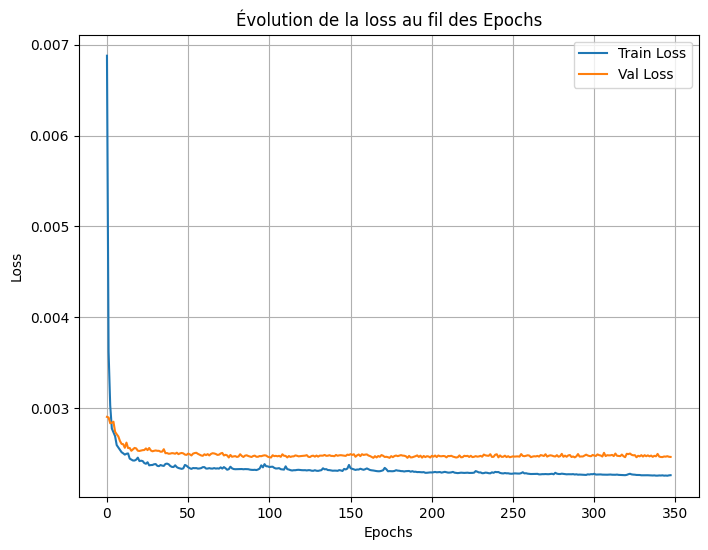

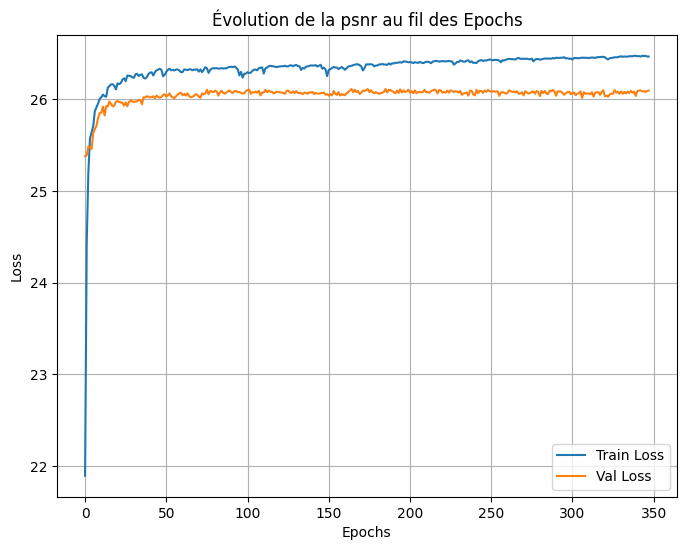

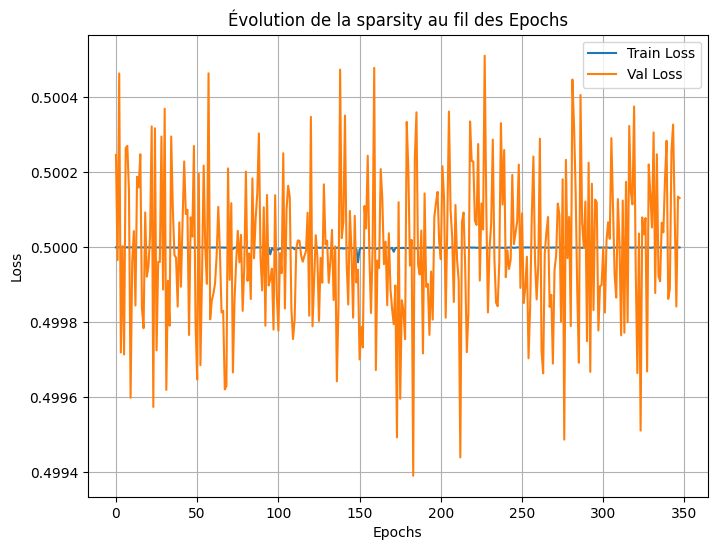

In [29]:
plot_loss(train_loss, val_loss[1:],"loss")
plot_loss(train_psnr, val_psnr[1:],"psnr")
plot_loss(train_sparsity, val_sparsity[1:],"sparsity")

In [25]:
import os
modelME = torch.load("epochs_NetME/" + "model_best.pth", map_location="cuda" if torch.cuda.is_available() else "cpu")
if os.path.exists("epochs_NetME/" + "model_best.pth"):
    modelME = NetME(nef = nef, NetE_name = 'epochs_NetE/' + modelE_name, sample_rate = sample_rate)
    #modelME = torch.load_state_dict(torch.load("epochs_NetME/" + "model_best.pth"))
    print("Model loaded")

print(type(modelME))

Model loaded
<class '__main__.NetME'>


In [30]:
print(mask_image.squeeze(0).permute(1, 2, 0).shape)


torch.Size([32, 32, 3])


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFile

# Load the image
tensor,_ = val_dataset[np.random.randint(0,len(val_dataset)-1)]
original_np = tensor.permute(1, 2, 0).numpy()

# Convert to torch tensor and rearrange dimensions to (C, H, W)
image = torch.tensor(original_np).permute(2, 0, 1).unsqueeze(0)  # Add batch dimension

# convert to cuda
if torch.cuda.is_available():
    image = image.cuda()
    modelME = modelME.cuda()


# Generate the corruption mask and reconstructed image
modelME.eval()
modelME.netM.eval()
modelME.netE.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

corrupt_mask_conti, _ = modelME(image)

corrupt_mask = corrupt_mask_conti.bernoulli()   # Binarize the corruption mask using Bernoulli distribution, then feed into modelE
corrupt_mask = corrupt_mask.expand(corrupt_mask.shape[0], 3, corrupt_mask.shape[2], corrupt_mask.shape[3])

#   Generate the corrupted image
mask_image = corrupt_mask * image

restored_image = modelME.netE(mask_image)

# Convert corrupted image to tensor
corrupted_tensor = torch.tensor(mask_image).squeeze(0).permute(1, 2, 0).cpu().numpy()  # Convert back to (H, W, C)

restored_image = restored_image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()  # Convert back to (H, W, C)

# Display results
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].imshow((original_np+1.0)/2.0)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow((corrupted_tensor+1.0)/2.0)
ax[1].set_title("Corrupted Image")
ax[1].axis("off")

ax[2].imshow((restored_image+1.0)/2.0)  # Clip values between 0-1
ax[2].set_title("Predicted Image")
ax[2].axis("off")

plt.show()


C:\Users\abdo-\AppData\Local\Temp\ipykernel_4352\3109152283.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  corrupted_tensor = torch.tensor(mask_image).permute(2, 0, 1).unsqueeze(0)


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFile

# Load the image
tensor,_ = val_dataset[np.random.randint(0,len(val_dataset)-1)]
original_np = tensor.permute(1, 2, 0).numpy()

# Convert to torch tensor and rearrange dimensions to (C, H, W)
image = torch.tensor(original_np).permute(2, 0, 1).unsqueeze(0)  # Add batch dimension

# convert to cuda
if torch.cuda.is_available():
    image = image.cuda()
    modelME = modelME.cuda()


# Generate the corruption mask and reconstructed image
modelME.eval()
modelME.netM.eval()
modelME.netE.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

corrupt_mask_conti, _ = modelME(image)

corrupt_mask = corrupt_mask_conti.bernoulli()   # Binarize the corruption mask using Bernoulli distribution, then feed into modelE
corrupt_mask = corrupt_mask.expand(corrupt_mask.shape[0], 3, corrupt_mask.shape[2], corrupt_mask.shape[3])

#   Generate the corrupted image
mask_image = corrupt_mask * image

restored_image = modelME.netE(mask_image)

# Convert corrupted image to tensor
corrupted_tensor = torch.tensor(mask_image).permute(2, 0, 1).unsqueeze(0)

restored_image = restored_image.squeeze(0).permute(1, 2, 0).cpu().numpy()  # Convert back to (H, W, C)

# Display results
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].imshow((original_np+1.0)/2.0)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow((corrupted_tensor+1.0)/2.0)
ax[1].set_title("Corrupted Image")
ax[1].axis("off")

ax[2].imshow((restored_image+1.0)/2.0)  # Clip values between 0-1
ax[2].set_title("Predicted Image")
ax[2].axis("off")

plt.show()


C:\Users\abdo-\AppData\Local\Temp\ipykernel_4352\3109152283.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  corrupted_tensor = torch.tensor(mask_image).permute(2, 0, 1).unsqueeze(0)


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3

In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFile

# Load the image
tensor,_ = val_dataset[np.random.randint(0,len(val_dataset)-1)]
original_np = tensor.permute(1, 2, 0).numpy()

# Convert to torch tensor and rearrange dimensions to (C, H, W)
image = torch.tensor(original_np).permute(2, 0, 1).unsqueeze(0)  # Add batch dimension

# convert to cuda
if torch.cuda.is_available():
    image = image.cuda()
    modelME = modelME.cuda()


# Generate the corruption mask and reconstructed image
modelME.eval()
modelME.netM.eval()
modelME.netE.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

corrupt_mask_conti, _ = modelME(image)

corrupt_mask = corrupt_mask_conti.bernoulli()   # Binarize the corruption mask using Bernoulli distribution, then feed into modelE
corrupt_mask = corrupt_mask.expand(corrupt_mask.shape[0], 3, corrupt_mask.shape[2], corrupt_mask.shape[3])

#   Generate the corrupted image
mask_image = corrupt_mask * image

restored_image = modelME.netE(mask_image)

# Convert corrupted image to tensor
corrupted_tensor = torch.tensor(mask_image).permute(2, 0, 1).unsqueeze(0)

restored_image = restored_image.squeeze(0).permute(1, 2, 0).cpu().numpy()  # Convert back to (H, W, C)

# Display results
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].imshow((original_np+1.0)/2.0)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow((corrupted_tensor+1.0)/2.0)
ax[1].set_title("Corrupted Image")
ax[1].axis("off")

ax[2].imshow((restored_image+1.0)/2.0)  # Clip values between 0-1
ax[2].set_title("Predicted Image")
ax[2].axis("off")

plt.show()


C:\Users\abdo-\AppData\Local\Temp\ipykernel_4352\3109152283.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  corrupted_tensor = torch.tensor(mask_image).permute(2, 0, 1).unsqueeze(0)


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3

In [39]:
print(mask_image.shape)

torch.Size([1, 3, 32, 32])


In [ ]:
def reshape_4D_array(array_4D, width_num):
    num, cha, height, width = array_4D.shape
    height_num = num // width_num
    total_width = width * width_num
    total_height = height * height_num
    target_array_4D = np.zeros((1, cha, total_height, total_width))
    for index in range(0, num):
        height_start = index // width_num
        width_start = index % width_num
        target_array_4D[:, :, height_start * height:height_start * height + height, width_start * width:width_start * width + width] = array_4D[index, :, :, :]
    return target_array_4D

def val(epoch):
    avg_psnr = 0
    avg_mse = 0
    avg_sparsity = 0

    modelME.eval()
    modelME.netM.eval()
    modelME.netE.eval()

    for batch in val_loader:
        target, _ = batch
        image = target.clone()
        image_clone = image.clone()

        mean_image = torch.zeros(image.shape[0], image.shape[1], image.shape[2], image.shape[3])
        mean_image[:,0,:,:] = 0.5
        mean_image[:,1,:,:] = 0.5
        mean_image[:,2,:,:] = 0.5

        std_image = torch.zeros(image.shape[0], image.shape[1], image.shape[2], image.shape[3])
        std_image[:,0,:,:] = 0.5
        std_image[:,1,:,:] = 0.5
        std_image[:,2,:,:] = 0.5

        if torch.cuda.is_available():
            image = image.cuda()
            image_clone = image_clone.cuda()
            target = target.cuda()
            mean_image = mean_image.cuda()
            std_image = std_image.cuda()

        # Generate the corruption mask and reconstructed image
        corrupt_mask_conti, _ = modelME(image)

        corrupt_mask = corrupt_mask_conti.bernoulli()   # Binarize the corruption mask using Bernoulli distribution, then feed into modelE
        mask_sparsity = corrupt_mask.sum() / (corrupt_mask.shape[0] * corrupt_mask.shape[1] * corrupt_mask.shape[2] * corrupt_mask.shape[3])
        corrupt_mask = corrupt_mask.expand(corrupt_mask.shape[0], 3, corrupt_mask.shape[2], corrupt_mask.shape[3])

        # Generate the corrupted image
        mask_image = corrupt_mask * image_clone

        restored_image = modelME.netE(mask_image)

        mse = criterion((restored_image*std_image)+mean_image, (target*std_image)+mean_image)
        psnr = 10 * log10(1 / mse.item())
        avg_psnr += psnr
        avg_mse  += mse.item()
        avg_sparsity += mask_sparsity

    print("===> Epoch {} Validation: Avg. Loss: {:.4f}, Avg.PSNR:  {:.4f} dB, Mask Sparsity: {:.4f}".format(epoch, avg_mse / len(val_loader), avg_psnr / len(val_loader), avg_sparsity / len(val_loader)))

    log_value('val_loss', avg_mse / len(val_loader), epoch)
    log_value('val_psnr', avg_psnr / len(val_loader), epoch)
    log_value('val_sparsity', avg_sparsity / len(val_loader), epoch)

    corrupt_mask_conti = corrupt_mask_conti.expand(corrupt_mask_conti.shape[0], 3, corrupt_mask_conti.shape[2], corrupt_mask_conti.shape[3])

    log_images('original_image', reshape_4D_array((image*std_image+mean_image).cpu().numpy(), 10), step=1)
    log_images('conti_mask', reshape_4D_array(corrupt_mask_conti.data.cpu().numpy(), 10), step=1)
    log_images('binar_mask', reshape_4D_array(corrupt_mask.data.cpu().numpy(), 10), step=1)
    log_images('restored_image', reshape_4D_array((restored_image*std_image+mean_image).data.cpu().numpy(), 10), step=1)

    global PSNR_best
    if avg_psnr > PSNR_best:
        PSNR_best = avg_psnr
        model_out_path = "epochs_NetME/" + "model_best.pth"
        torch.save(modelME.state_dict(), model_out_path)
        print("Checkpoint saved to {}".format(model_out_path))

# Initialize global PSNR_best
PSNR_best = 0

# Run the validation function for one epoch with random data
val(0)

In [ ]:
import torch
import numpy as np
from math import ceil
def reshape_4D_array(array_4D, width_num):
    num, cha, height, width = array_4D.shape
    height_num = ceil(num / width_num)
    total_width = width * width_num
    total_height = height * height_num
    target_array_4D = np.zeros((1, cha, total_height, total_width))
    for index in range(0, num):
        height_start = index // width_num
        width_start = index % width_num
        target_array_4D[:, :, height_start * height:height_start * height + height, width_start * width:width_start * width + width] = array_4D[index, :, :, :]
    return target_array_4D



test = torch.zeros(3,3,64,64)
reshape_4D_array(test,10).shape

(1, 3, 64, 640)